# Using Attention Mechanisms for Sentiment Analysis

Yet another task, yet another notebook. This time we focus on attention mechanisms and use the IMDB Movie Reviews Dataset for sentiment analysis.

## Load Up the Data

The task is binary classification in its core, so I figure the main part is to just prepare the data.

Anyway, let us get working now. We begin by importing some libraries.

In [10]:
import torch
import torch.nn as nn
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/devansh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/devansh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/devansh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/devansh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Next, let's load the dataset we will be using. Note that the data is being loaded from Huggingface itself, so it will require an access token.

In [11]:
splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["test"])
df = pd.concat([df_train, df_test])

In [12]:
df.head()

text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0

Alright, so 0 means negative and 1 is positive, I suppose... Let's now work on the processing, where we will tokenize the text, index the tokens and embed them.

In [13]:
from collections import Counter

stop_words = set(stopwords.words('english'))

def clean_and_tokenize_text(text):
    # Helper function which removes unnecessary characters and splits the text into tokens
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return tokens

def build_vocab(token_lists, min_freq=1):

    # Makes a vocabulary indexing of the tokens
    counter = Counter(token for tokens in token_lists for token in tokens)
    vocab = {"<PAD>": 0, "<UNK>": 1}
    idx = 2
    for token, freq in counter.items():
        if freq >= min_freq:
            vocab[token] = idx
            idx += 1
    return vocab

def tokens_to_indices(tokens, vocab):
    # Uses said indexing to index each token list
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

# tokenize once, store
tokenized_text = [clean_and_tokenize_text(text) for text in df['text']]
word2idx = build_vocab(tokenized_text, min_freq=1)

df['encoded_text'] = [
    tokens_to_indices(tokens, word2idx)
    for tokens in tokenized_text
]

df

text  label  \
0      I rented I AM CURIOUS-YELLOW from my video sto...      0   
1      "I Am Curious: Yellow" is a risible and preten...      0   
2      If only to avoid making this type of film in t...      0   
3      This film was probably inspired by Godard's Ma...      0   
4      Oh, brother...after hearing about this ridicul...      0   
...                                                  ...    ...   
24995  Just got around to seeing Monster Man yesterda...      1   
24996  I got this as part of a competition prize. I w...      1   
24997  I got Monster Man in a box set of three films ...      1   
24998  Five minutes in, i started to feel how naff th...      1   
24999  I caught this movie on the Sci-Fi channel rece...      1   

                                            encoded_text  
0      [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 8, 12, 13, 14...  
1      [123, 124, 125, 126, 127, 128, 121, 129, 130, ...  
2      [224, 43, 225, 104, 226, 104, 227, 228, 229, 2...  
3      [104, 260, 261, 262, 263, 264, 265, 25, 104, 2...  
4      [302, 303, 304, 305, 104, 306, 70, 307, 95, 30...  
...                                                  ...  
24995  [346, 29, 2358, 3636, 201, 5265, 680, 1134, 34...  
24996  [346, 688, 3469, 13775, 1388, 24, 4452, 122, 4...  
24997  [346, 3636, 201, 3568, 953, 1942, 21, 9617, 20...  
24998  [849, 995, 831, 233, 38132, 652, 884, 346, 129...  
24999  [3040, 300, 6873, 2585, 2253, 1368, 2799, 517,...  

[50000 rows x 3 columns]

Next, we will apply padding to the data, and make a DataLoader for it. But before that, we shall split the data into training, validation and test sets.

We will keep 80% for training, and 10% each for validation and testing.

In [18]:
from sklearn.model_selection import train_test_split

# First split: train vs (val + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],   # preserve positive/negative balance if labeled
    random_state=42
)

# Then split val and test from that 20%
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print(f"Train: {len(train_df)}")
print(f"Val: {len(val_df)}")
print(f"Test: {len(test_df)}")


Train: 40000
Val: 5000
Test: 5000


Next, let's do our further processing for each set.

We will pad each sequence, and load the sequence, its original length and its label into a DataLoader.

The reason we are adding the length is because we will use packing in the rnn which will make sure that our models do not learn or process the extra padding in the sequences.

In [19]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def pad_seqs(encoded_seqs):
  # Function that pads up the shorter sequences

  tensor_seqs = [torch.tensor(seq) for seq in encoded_seqs]
  padded = pad_sequence(tensor_seqs, batch_first=True, padding_value = word2idx['<PAD>'])
  lengths = torch.tensor([len(seq) for seq in tensor_seqs])

  return padded, lengths

class TextDataset(torch.utils.data.Dataset):
    # Class tailored for our data.

    def __init__(self, padded_seqs, lengths, labels):
        self.padded_seqs = padded_seqs  # [N, max_len]
        self.lengths = lengths          # [N]
        self.labels = labels            # [N]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            self.padded_seqs[idx],     # tensor [max_len]
            self.lengths[idx],        # scalar
            self.labels[idx]           # scalar
        )

def split_df(df):
  padded_seqs, lengths = pad_seqs(df['encoded_text'])
  labels = torch.tensor(df['label'].values)
  return TextDataset(padded_seqs, lengths, labels)

train_dataset = split_df(train_df)
val_dataset = split_df(val_df)
test_dataset = split_df(test_df)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

Alright, now let's define the base models which we will be using.

- RNN
- LSTM
- Bidirectional RNN
- Bidirectional LSTM


We will first use these models, and then we will apply attention mechanisms to each of them.

The four models below are quite similar in architecture. They each have a dedicated neural network for sequence processing followed by a fully connected layer for classification. Hence the training and evaluation remains very much the same.

In [16]:
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from sklearn.metrics import accuracy_score, classification_report

class VanillaRNN(nn.Module):

  def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, num_classes)

  def forward(self, x, lengths):
    embed = self.embedding(x)

    packed = pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)
    _, hidden = self.rnn(packed)

    logits = self.fc(hidden.squeeze(0))
    return logits

  def fit(self, train_loader, val_loader=None, epochs=5, lr=1e-3, device='cpu', stopping_criterion=1e-2):
    optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    self.to(device)
    self.train()

    for epoch in range(epochs):
      self.train()
      total_loss = 0
      for x, lengths, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        lengths = lengths.cpu()

        optimizer.zero_grad()
        logits = self(x, lengths)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

      avg_loss = total_loss / len(train_loader)
      print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')

      if val_loader:
        self.evaluate(val_loader, device)

  def evaluate(self, val_loader, device,report=False):
    self.eval()
    with torch.no_grad():
      preds = torch.tensor([], dtype=torch.long)
      true = torch.tensor([], dtype=torch.long)
      for x, lengths, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        lengths = lengths.cpu()

        logits = self(x,lengths)
        preds_batch = torch.argmax(logits, dim=1)
        preds = torch.cat([preds, preds_batch.cpu()])
        true = torch.cat([true, y.cpu()])

      if report:
        print(classification_report(true, preds))
      else:
        print(f'Validation Accuracy: {accuracy_score(true, preds):.4f}')

class BiRNN(nn.Module):

  def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(2 * hidden_dim, num_classes)

  def forward(self, x, lengths):
    embed = self.embedding(x)

    packed = pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)
    _, hidden = self.rnn(packed)
    hidden_cat = torch.cat((hidden[0,:,:], hidden[1,:,:]), dim=1)
    logits = self.fc(hidden_cat)
    return logits

  def fit(self, train_loader, val_loader=None, epochs=5, lr=1e-3, device='cpu', stopping_criterion=1e-2):
    optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    self.to(device)
    self.train()

    for epoch in range(epochs):
      self.train()
      total_loss = 0
      for x, lengths, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        lengths = lengths.cpu()

        optimizer.zero_grad()
        logits = self(x, lengths)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

      avg_loss = total_loss / len(train_loader)
      print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')

      if val_loader:
        self.evaluate(val_loader, device)

  def evaluate(self, val_loader, device,report=False):
    self.eval()
    with torch.no_grad():
      preds = torch.tensor([], dtype=torch.long)
      true = torch.tensor([], dtype=torch.long)
      for x, lengths, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        lengths = lengths.cpu()

        logits = self(x,lengths)
        preds_batch = torch.argmax(logits, dim=1)
        preds = torch.cat([preds, preds_batch.cpu()])
        true = torch.cat([true, y.cpu()])

      if report:
        print(classification_report(true, preds))
      else:
        print(f'Validation Accuracy: {accuracy_score(true, preds):.4f}')

class VanillaLSTM(nn.Module):
  def __init__(self, vocab_size, hidden_dim, embed_dim, num_classes):
     super().__init__()
     self.embedding = nn.Embedding(vocab_size, embedding_dim=embed_dim, padding_idx=word2idx['<PAD>'])
     self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
     self.fc = nn.Linear(hidden_dim, num_classes)

  def forward(self, x, lengths):
    embed = self.embedding(x)

    packed = pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)
    _, (hidden,cell) = self.rnn(packed)

    logits = self.fc(hidden.squeeze(0))
    return logits

  def fit(self, train_loader, val_loader=None, epochs=5, lr=1e-3, device='cpu', stopping_criterion=1e-2):
    optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    self.to(device)
    self.train()

    for epoch in range(epochs):
      self.train()
      total_loss = 0
      for x, lengths, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        lengths = lengths.cpu()

        optimizer.zero_grad()
        logits = self(x, lengths)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

      avg_loss = total_loss / len(train_loader)
      print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')

      if val_loader:
        self.evaluate(val_loader, device)

  def evaluate(self, val_loader, device,report=False):
    self.eval()
    with torch.no_grad():
      preds = torch.tensor([], dtype=torch.long)
      true = torch.tensor([], dtype=torch.long)
      for x, lengths, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        lengths = lengths.cpu()

        logits = self(x,lengths)
        preds_batch = torch.argmax(logits, dim=1)
        preds = torch.cat([preds, preds_batch.cpu()])
        true = torch.cat([true, y.cpu()])

      if report:
        print(classification_report(true, preds))
      else:
        print(f'Validation Accuracy: {accuracy_score(true, preds):.4f}')

class BiLSTM(nn.Module):
  def __init__(self, vocab_size, hidden_dim, embed_dim, num_classes):
     super().__init__()
     self.embedding = nn.Embedding(vocab_size, embedding_dim=embed_dim, padding_idx=word2idx['<PAD>'])
     self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
     self.fc = nn.Linear(2*hidden_dim, num_classes)

  def forward(self, x, lengths):
    embed = self.embedding(x)

    packed = pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)
    _, (hidden,cell) = self.rnn(packed)
    hidden_cat = torch.cat((hidden[0,:,:], hidden[1,:,:]), dim=1)
    logits = self.fc(hidden_cat)
    return logits

  def fit(self, train_loader, val_loader=None, epochs=5, lr=1e-3, device='cpu', stopping_criterion=1e-2):
    optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    self.to(device)
    self.train()

    for epoch in range(epochs):
      self.train()
      total_loss = 0
      for x, lengths, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        lengths = lengths.cpu()

        optimizer.zero_grad()
        logits = self(x, lengths)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

      avg_loss = total_loss / len(train_loader)
      print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')

      if val_loader:
        self.evaluate(val_loader, device)

  def evaluate(self, val_loader, device,report=False):
    self.eval()
    with torch.no_grad():
      preds = torch.tensor([], dtype=torch.long)
      true = torch.tensor([], dtype=torch.long)
      for x, lengths, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        lengths = lengths.cpu()

        logits = self(x,lengths)
        preds_batch = torch.argmax(logits, dim=1)
        preds = torch.cat([preds, preds_batch.cpu()])
        true = torch.cat([true, y.cpu()])

      if report:
        print(classification_report(true, preds))
      else:
        print(f'Validation Accuracy: {accuracy_score(true, preds):.4f}')

Let us now train these four models.

In [39]:

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vrnn = VanillaRNN(vocab_size = len(word2idx), embed_dim = 200, hidden_dim = 256, num_classes=2)
vrnn.fit(train_loader, val_loader, epochs=10,device=device)

Epoch 1, Training Loss: 0.6418
Validation Accuracy: 0.5854
Epoch 2, Training Loss: 0.5841
Validation Accuracy: 0.7170
Epoch 3, Training Loss: 0.5734
Validation Accuracy: 0.7682
Epoch 4, Training Loss: 0.5919
Validation Accuracy: 0.6698
Epoch 5, Training Loss: 0.5148
Validation Accuracy: 0.7386
Epoch 6, Training Loss: 0.4972
Validation Accuracy: 0.6110
Epoch 7, Training Loss: 0.5355
Validation Accuracy: 0.7048
Epoch 8, Training Loss: 0.3754
Validation Accuracy: 0.7608
Epoch 9, Training Loss: 0.4976
Validation Accuracy: 0.6430
Epoch 10, Training Loss: 0.5164
Validation Accuracy: 0.6196


Next up is a convenient function to evaluate the model.

Accuracy: 0.6336
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      2500
           1       0.64      0.61      0.63      2500

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.63      5000
weighted avg       0.63      0.63      0.63      5000

Confusion Matrix:
[[1637  863]
 [ 969 1531]]


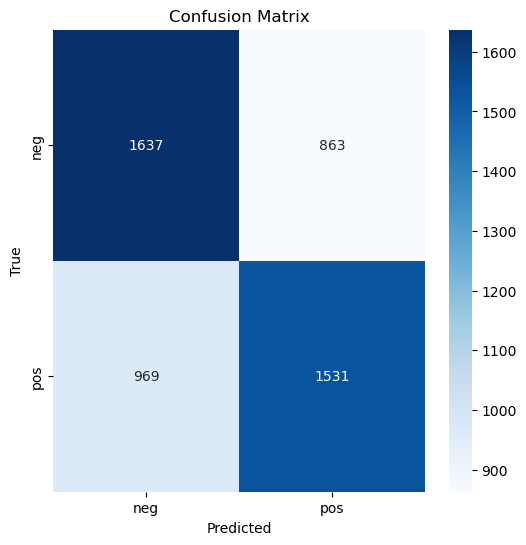

In [42]:
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, device="cpu", visualize_attention=False, label_names=None):
    """
    Evaluates the given model on a data loader.

    Args:
        model: the trained model (with .eval())
        data_loader: DataLoader object for evaluation
        device: 'cuda' or 'cpu'
        visualize_attention: if True, will try to plot attention maps for 5 random samples
        label_names: optional list of label names for confusion matrix

    Returns:
        metrics dict with accuracy, precision, recall, f1, confusion matrix
    """
    model.eval()
    all_preds = []
    all_true = []
    all_attns = []  # to store attention if applicable

    with torch.no_grad():
        for x, lengths, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            lengths = lengths.cpu()

            if visualize_attention:
                logits, alphas = model(x, lengths)
                all_attns.append(alphas.cpu())
            else:
                logits = model(x, lengths)[0] if isinstance(model(x, lengths), tuple) else model(x, lengths)

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_true.extend(y.cpu().tolist())

    acc = accuracy_score(all_true, all_preds)
    report = classification_report(all_true, all_preds, output_dict=True)
    cm = confusion_matrix(all_true, all_preds)

    # print metrics
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(all_true, all_preds))
    print("Confusion Matrix:")
    print(cm)

    # confusion matrix plot
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # attention visualization (bonus)
    if visualize_attention and len(all_attns) > 0:
        print("Visualizing attention for 5 random samples...")
        for idx, attn in enumerate(all_attns[:5]):
            plt.figure(figsize=(10, 4))
            sns.heatmap(attn.numpy(), cmap="viridis")
            plt.title(f"Attention Weights Sample {idx+1}")
            plt.xlabel("Source Tokens")
            plt.ylabel("Attention Head / Position")
            plt.show()

    return {
        "accuracy": acc,
        "precision": report['weighted avg']['precision'],
        "recall": report['weighted avg']['recall'],
        "f1": report['weighted avg']['f1-score'],
        "confusion_matrix": cm
    }

evals = {}
evals['vrnn'] = evaluate_model(vrnn, test_loader, device=device, label_names = ['neg','pos'])

Well, this seems to be performing quite decently. Let us train the next model!

Epoch 1, Training Loss: 0.4806
Validation Accuracy: 0.8208
Epoch 2, Training Loss: 0.3150
Validation Accuracy: 0.8580
Epoch 3, Training Loss: 0.3606
Validation Accuracy: 0.8616
Epoch 4, Training Loss: 0.2012
Validation Accuracy: 0.8542
Epoch 5, Training Loss: 0.1235
Validation Accuracy: 0.8704
Epoch 6, Training Loss: 0.0672
Validation Accuracy: 0.8646
Epoch 7, Training Loss: 0.0394
Validation Accuracy: 0.8538
Epoch 8, Training Loss: 0.0285
Validation Accuracy: 0.8598
Epoch 9, Training Loss: 0.0156
Validation Accuracy: 0.8570
Epoch 10, Training Loss: 0.0176
Validation Accuracy: 0.8642
Accuracy: 0.8738
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2500
           1       0.88      0.87      0.87      2500

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion Matrix:
[[2194  306]
 [ 325 2175

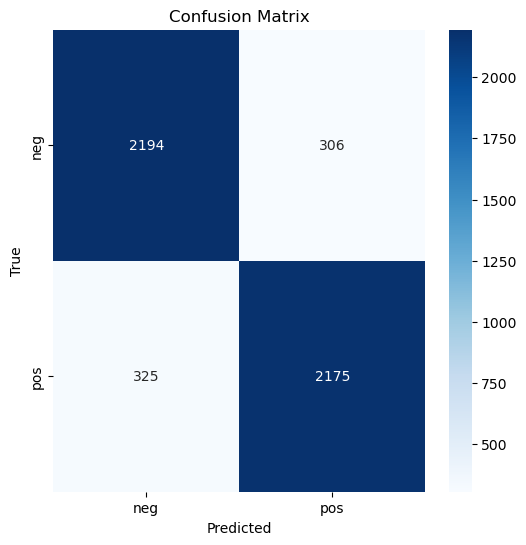

In [44]:
vlstm = VanillaLSTM(vocab_size = len(word2idx), hidden_dim = 200, embed_dim = 256, num_classes=2)
vlstm.fit(train_loader, val_loader, epochs=10, device=device)
evals['vlstm'] = evaluate_model(vlstm, test_loader, device=device, label_names = ['neg','pos'])

Well, the LSTM performs somewhat better than the RNN.

Let's see what we can get with the bidirectional models now.

Bidirectional RNN
Epoch 1, Training Loss: 0.6288
Validation Accuracy: 0.7152
Epoch 2, Training Loss: 0.5505
Validation Accuracy: 0.7656
Epoch 3, Training Loss: 0.5182
Validation Accuracy: 0.6484
Epoch 4, Training Loss: 0.5062
Validation Accuracy: 0.7162
Epoch 5, Training Loss: 0.3988
Validation Accuracy: 0.7968
Epoch 6, Training Loss: 0.3299
Validation Accuracy: 0.8126
Epoch 7, Training Loss: 0.2438
Validation Accuracy: 0.7190
Epoch 8, Training Loss: 0.4741
Validation Accuracy: 0.7834
Epoch 9, Training Loss: 0.2687
Validation Accuracy: 0.7358
Epoch 10, Training Loss: 0.2853
Validation Accuracy: 0.7020
Accuracy: 0.7168
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      2500
           1       0.75      0.65      0.70      2500

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000

Confusion Matrix:
[[1970

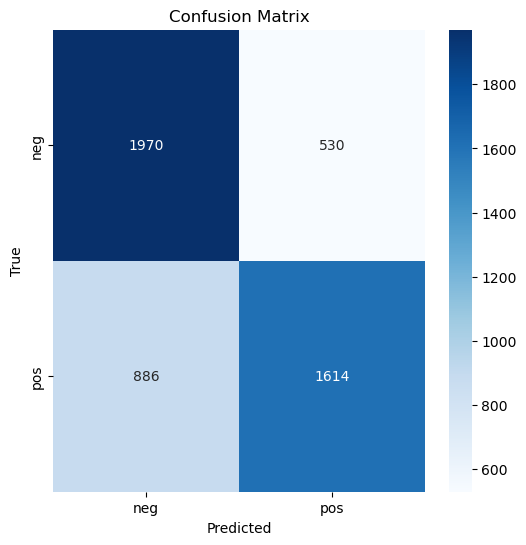

In [55]:
birnn = BiRNN(vocab_size = len(word2idx), hidden_dim = 200, embed_dim = 256, num_classes=2)
print("Bidirectional RNN")
birnn.fit(train_loader, val_loader, epochs=10, device=device)
evals['birnn'] = evaluate_model(birnn, test_loader, device=device, label_names = ['neg','pos'])
torch.save(birnn.state_dict(),'BiRNN.pt')

bilstm = BiLSTM(vocab_size = len(word2idx), hidden_dim=200, embed_dim=256, num_classes=2)
print("Bidirectional LSTM")
bilstm.fit(train_loader, val_loader, epochs=10, device=device)
evals['birnn'] = evaluate_model(bilstm, test_loader, device=device, label_names = ['neg','pos'])

Alright, so our bidirectional models seem to be performing well too.

Now, let us implement attention mechanisms. We will focus on 4 types of attention:

- Additive Attention
- Luong Dot Attention
- Luong General Attention
- Concat Attention

Here's an implementation below, along with a wrapper class that accepts a model and attention mechanism and adds attention to the model.

In [35]:
class Attention(nn.Module):
  def forward(self, enc_states, dec_state):
    raise NotImplementedError()

class AdditiveAttention(Attention):
    def __init__(self, enc_dim, dec_dim, att_dim):
        super().__init__()
        self.dec_proj = nn.Linear(dec_dim, att_dim)
        self.enc_proj = nn.Linear(enc_dim, att_dim)
        self.att_proj = nn.Linear(att_dim, 1)

    def forward(self, dec_state, enc_states):
        enc_proj = self.enc_proj(enc_states)
        dec_proj = self.dec_proj(dec_state).unsqueeze(0)
        scores   = self.att_proj(torch.tanh(enc_proj + dec_proj))
        alpha    = torch.softmax(scores.squeeze(2), dim=0)
        ctx      = torch.sum(alpha.unsqueeze(2) * enc_states, dim=0)
        return ctx, alpha

class DotAttention(Attention):
  def __init__(self, enc_dim, dec_dim, att_dim=None):
      super().__init__()
      if enc_dim != dec_dim:
        self.proj = nn.Linear(enc_dim, dec_dim, bias=False)
      else:
        self.proj = None

  def forward(self, dec_state, enc_states):
    if self.proj is not None:
      enc_states = self.proj(enc_states)

    scores = torch.sum(enc_states * dec_state.unsqueeze(0), dim=2)
    alpha = torch.softmax(scores, dim=0)
    ctx = torch.sum(alpha.unsqueeze(2) * enc_states, dim=0)
    return ctx, alpha

class GeneralAttention(Attention):
  def __init__(self, enc_dim, dec_dim, att_dim=None) -> None:
      super().__init__()
      self.W = nn.Linear(enc_dim, dec_dim)

  def forward(self, dec_state, enc_states):
    scores = torch.sum(self.W(enc_states) * dec_state, dim=2)
    alpha = torch.softmax(scores, dim=0)
    ctx = torch.sum(alpha.unsqueeze(2)*enc_states, dim=0)
    return ctx, alpha

class ConcatAttention(Attention):
    def __init__(self, enc_dim, dec_dim, att_dim):
        super().__init__()
        self.Wa = nn.Linear(enc_dim + dec_dim, att_dim)
        self.va = nn.Linear(att_dim, 1)

    def forward(self, dec_state, enc_states):
        seq_len, batch_size, _ = enc_states.shape

        dec_repeat = dec_state.unsqueeze(0).repeat(seq_len, 1, 1)
        concat = torch.cat([enc_states, dec_repeat], dim=2)
        energy = torch.tanh(self.Wa(concat))
        scores = self.va(energy).squeeze(2)

        alpha = torch.softmax(scores, dim=0)
        ctx = torch.sum(alpha.unsqueeze(2) * enc_states, dim=0)

        return ctx, alpha

class AttentionClassifier(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, encoder_rnn, attention_mech):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=word2idx['<PAD>'])
    self.encoder = encoder_rnn
    self.attention = attention_mech
    self.fc = nn.Linear(hidden_dim * (2 if getattr(self.encoder, 'bidirectional', False) else 1), num_classes)

  def forward(self, x, lengths):
    embed = self.embedding(x)
    packed = pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)

    if isinstance(self.encoder, nn.LSTM):
      enc_outs, (h,_) = self.encoder(packed)
    else:
      enc_outs, h = self.encoder(packed)

    enc_outs, _ = pad_packed_sequence(enc_outs, batch_first=True)
    enc_outs = enc_outs.transpose(0,1)

    if getattr(self.encoder, 'bidirectional', False):
      query = torch.cat((h[-2], h[-1]), dim=1)
    else:
      query = h[-1]

    ctx, alpha = self.attention(query, enc_outs)
    logits = self.fc(ctx)

    return logits, alpha

  def fit(self, train_loader, val_loader=None, epochs=5, lr=1e-3, device='cpu'):
    optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    self.to(device)

    for epoch in range(epochs):
        self.train()
        total_loss = 0
        for x, lengths, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            lengths = lengths.cpu()

            optimizer.zero_grad()
            logits, _ = self(x, lengths)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}")

        if val_loader:
            self.evaluate(val_loader, device)


  def evaluate(self, val_loader, device, report=False):
      self.eval()
      from sklearn.metrics import classification_report, accuracy_score

      all_preds = []
      all_true  = []

      with torch.no_grad():
          for x, lengths, y in val_loader:
              x = x.to(device)
              y = y.to(device)
              lengths = lengths.cpu()

              logits, _ = self(x, lengths)
              preds = torch.argmax(logits, dim=1)

              all_preds.extend(preds.cpu().tolist())
              all_true.extend(y.cpu().tolist())

      if report:
          print(classification_report(all_true, all_preds))
      else:
          acc = accuracy_score(all_true, all_preds)
          print(f"Validation Accuracy: {acc:.4f}")


We won't do the training process here since it would take hours to train the sixteen models. Instead, the models have already been trained, and we will just load up the weights and evaluate their performance.

In [26]:
import torch
import os

# directory where your .pt files are stored
WEIGHTS_DIR = "./weights"  # change if needed

# list of encoders you had
encoders = [
    "VanillaRNN",
    "VanillaLSTM",
    "BiRNN",
    "BiLSTM"
]

# list of attentions you had
attentions = [
    "AdditiveAttention",
    "DotAttention",
    "GeneralAttention",
    "ConcatAttention"
]

# will store loaded state dicts
model_weights = {}

for encoder in encoders:
    for attention in attentions:
        filename = f"{encoder}_{attention}.pt"
        filepath = os.path.join(WEIGHTS_DIR, filename)
        if os.path.exists(filepath):
            print(f"Loading {filename} ...")
            state_dict = torch.load(filepath, map_location="cpu")
            model_weights[(encoder, attention)] = state_dict
        else:
            print(f"{filename} not found, skipping.")

print(f"\nLoaded {len(model_weights)} models.")


Loading VanillaRNN_AdditiveAttention.pt ...
Loading VanillaRNN_DotAttention.pt ...
Loading VanillaRNN_GeneralAttention.pt ...
Loading VanillaRNN_ConcatAttention.pt ...
Loading VanillaLSTM_AdditiveAttention.pt ...
Loading VanillaLSTM_DotAttention.pt ...
Loading VanillaLSTM_GeneralAttention.pt ...
Loading VanillaLSTM_ConcatAttention.pt ...
Loading BiRNN_AdditiveAttention.pt ...
Loading BiRNN_DotAttention.pt ...
Loading BiRNN_GeneralAttention.pt ...
Loading BiRNN_ConcatAttention.pt ...
Loading BiLSTM_AdditiveAttention.pt ...
Loading BiLSTM_DotAttention.pt ...
Loading BiLSTM_GeneralAttention.pt ...
Loading BiLSTM_ConcatAttention.pt ...

Loaded 16 models.


We'll go one by one as per the attention mechanism. Let us begin with Additive Attention.

Below is a helper function to evalute the model and also the attention weights.


--- Evaluating VanillaRNN + AdditiveAttention ---
Accuracy: 0.8620
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2500
           1       0.86      0.86      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Confusion Matrix:
[[2153  347]
 [ 343 2157]]


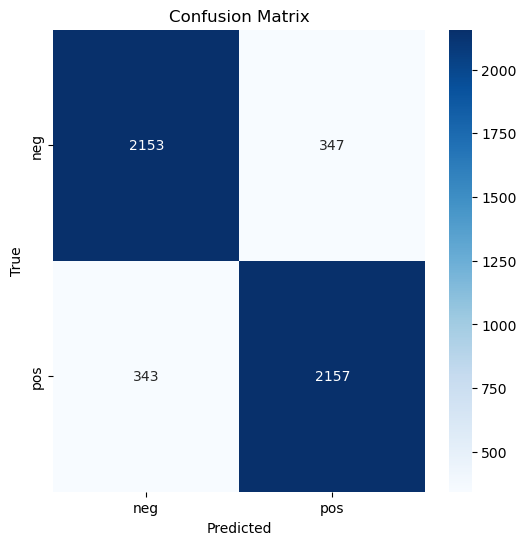

Visualizing attention for 5 random samples...


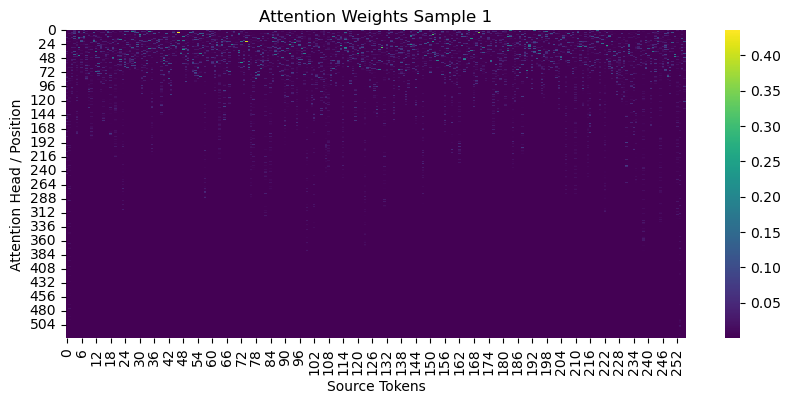

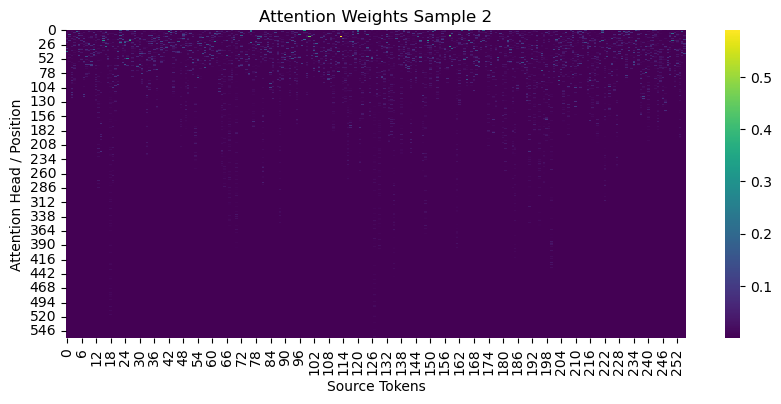

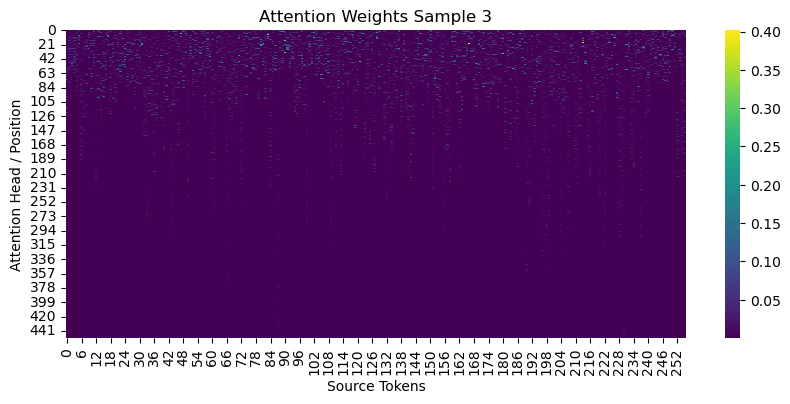

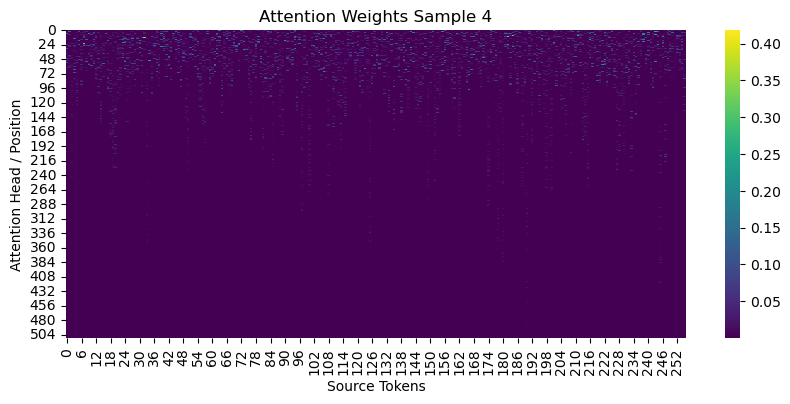

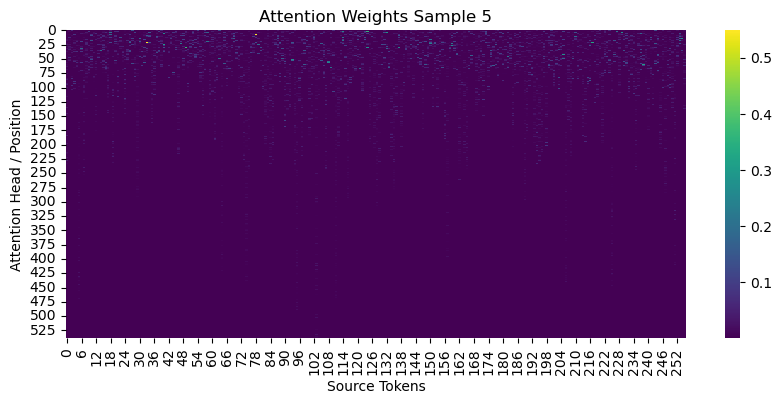


--- Evaluating VanillaLSTM + AdditiveAttention ---
Accuracy: 0.8748
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2500
           1       0.87      0.88      0.88      2500

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion Matrix:
[[2175  325]
 [ 301 2199]]


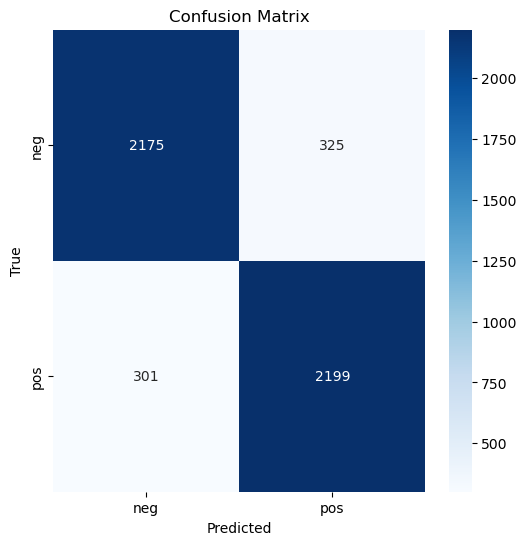

Visualizing attention for 5 random samples...


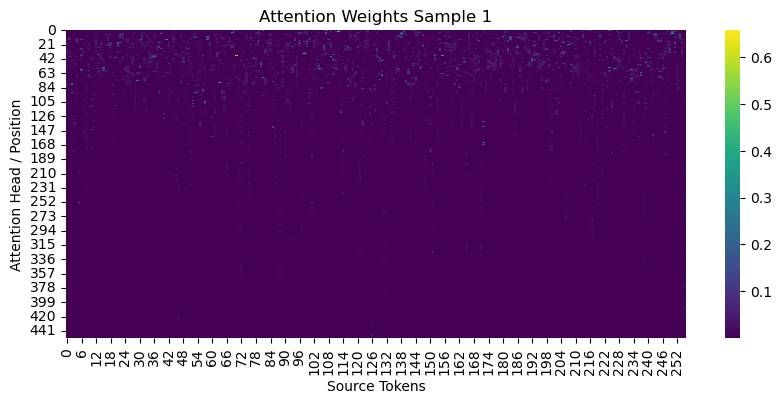

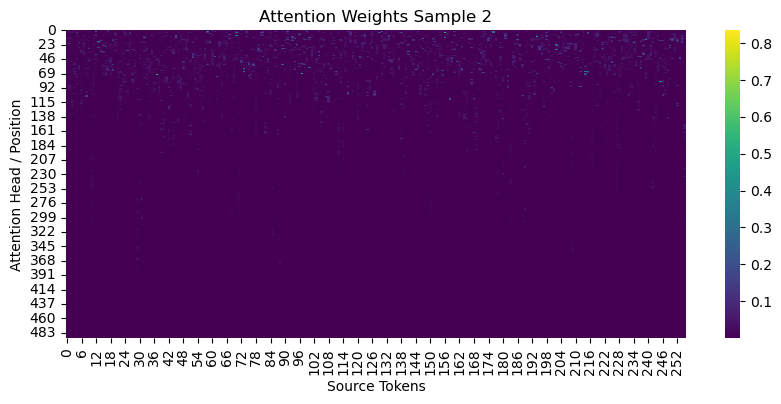

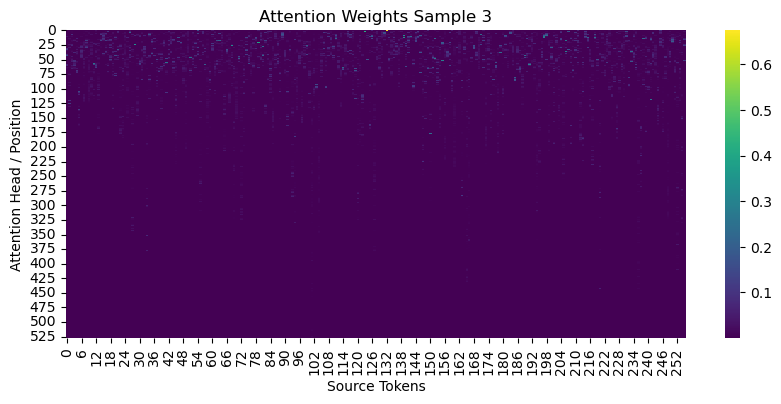

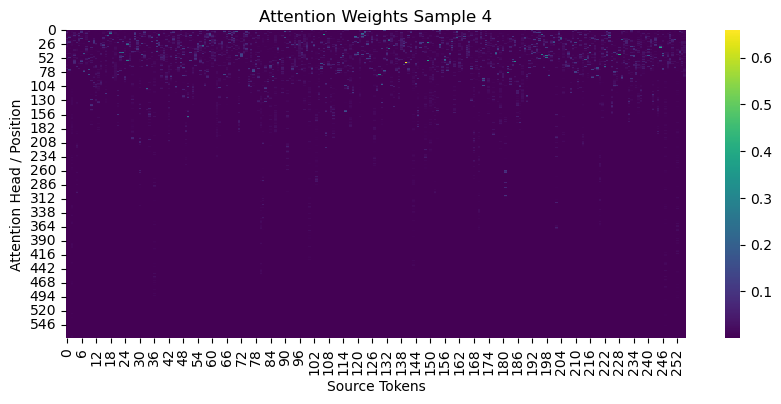

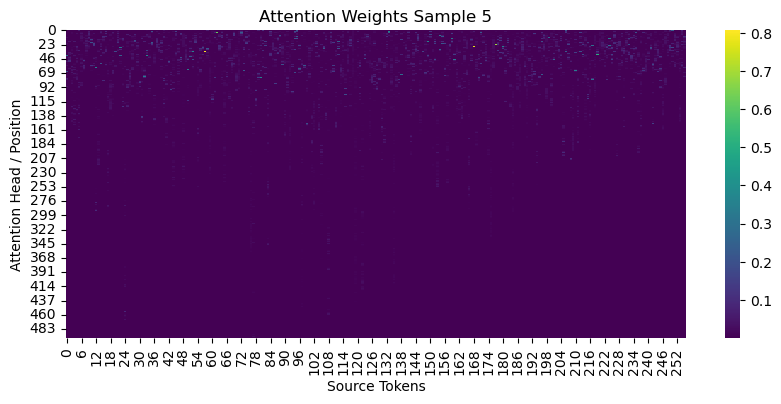


--- Evaluating BiRNN + AdditiveAttention ---
Accuracy: 0.8654
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2500
           1       0.88      0.84      0.86      2500

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion Matrix:
[[2222  278]
 [ 395 2105]]


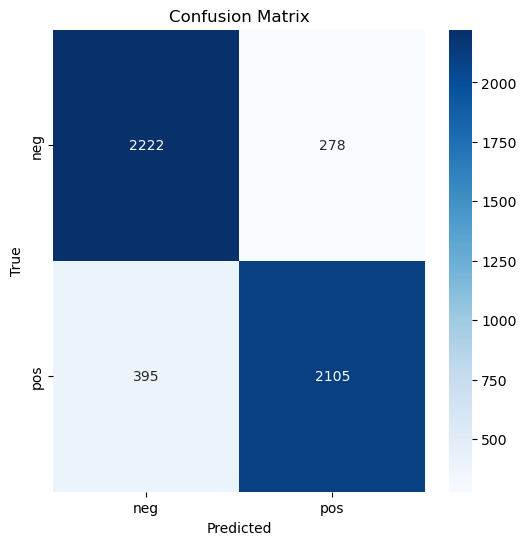

Visualizing attention for 5 random samples...


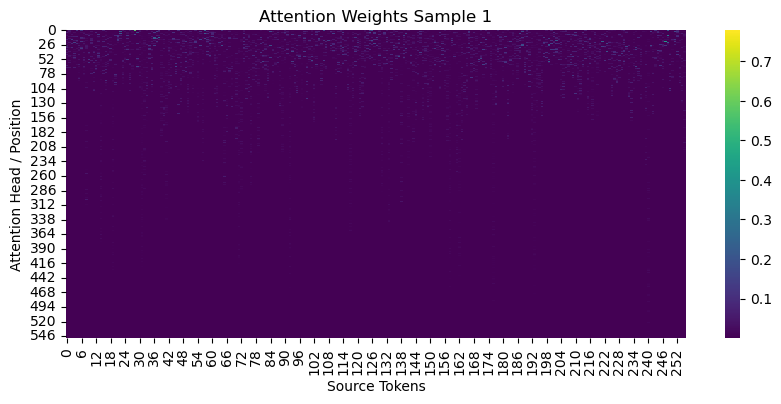

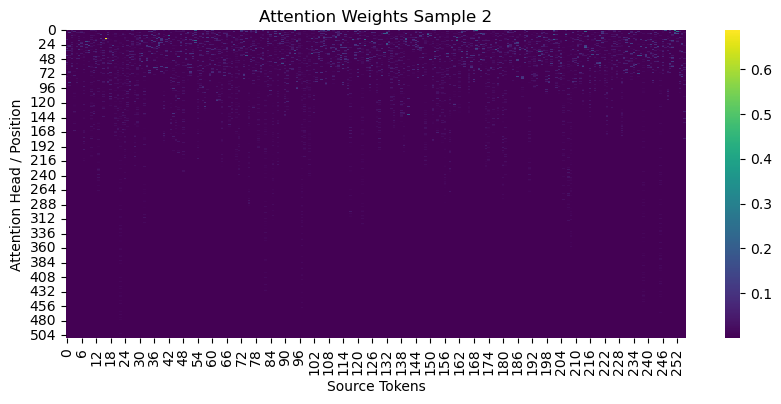

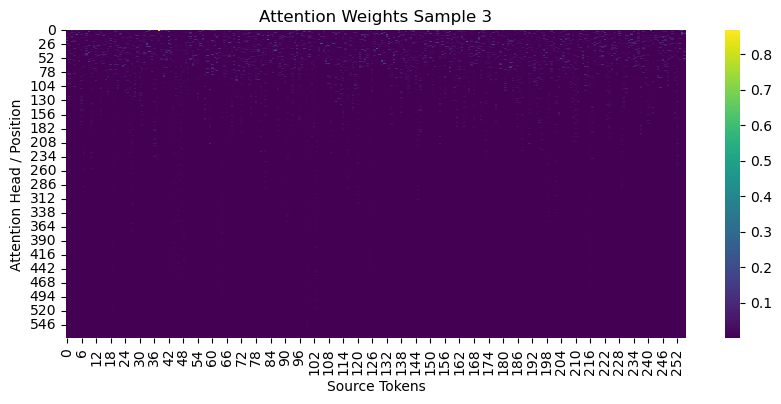

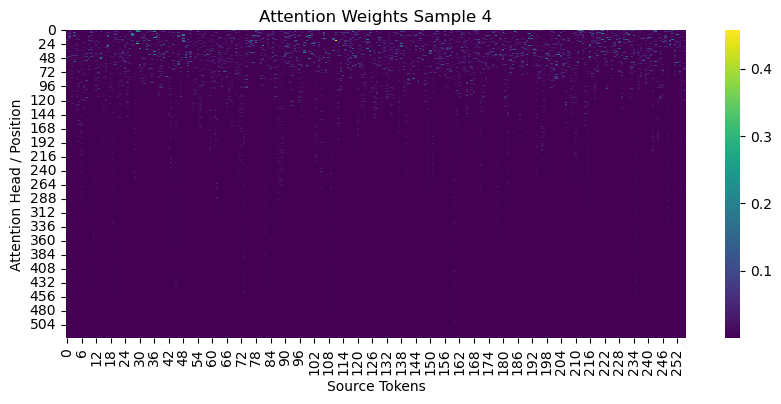

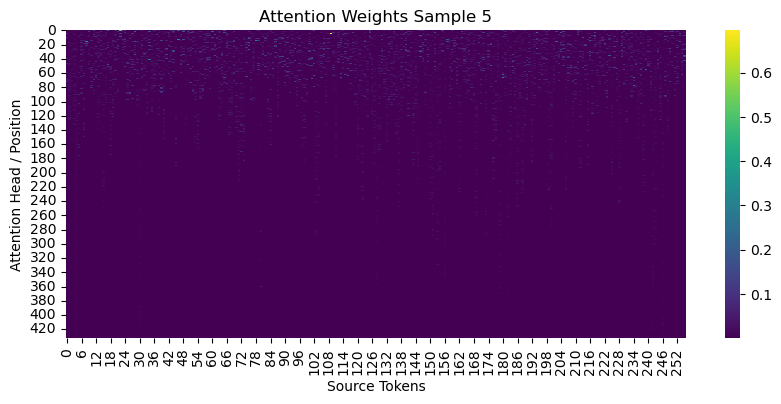


--- Evaluating BiLSTM + AdditiveAttention ---
Accuracy: 0.8778
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      2500
           1       0.86      0.90      0.88      2500

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

Confusion Matrix:
[[2128  372]
 [ 239 2261]]


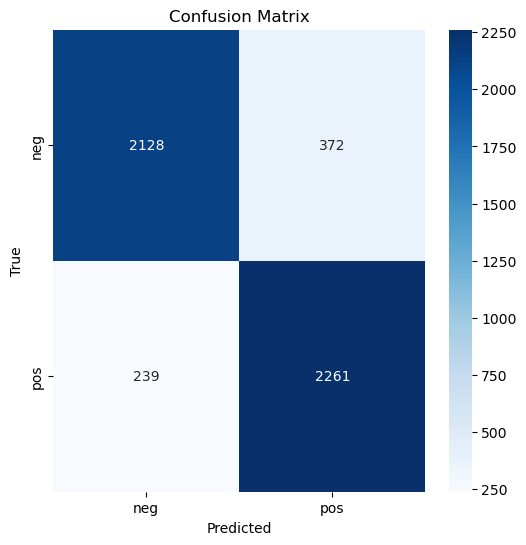

Visualizing attention for 5 random samples...


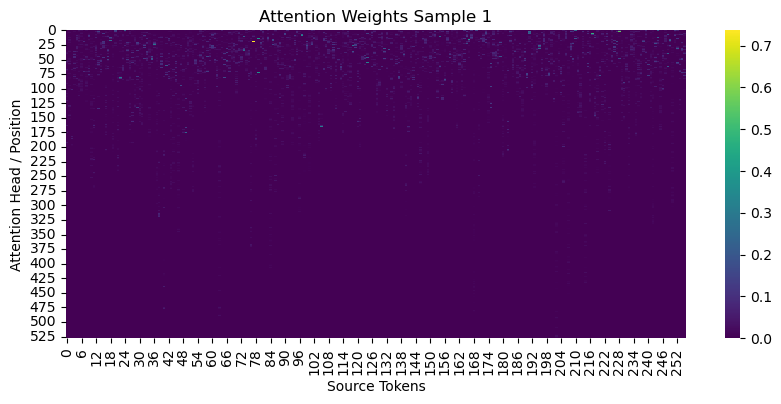

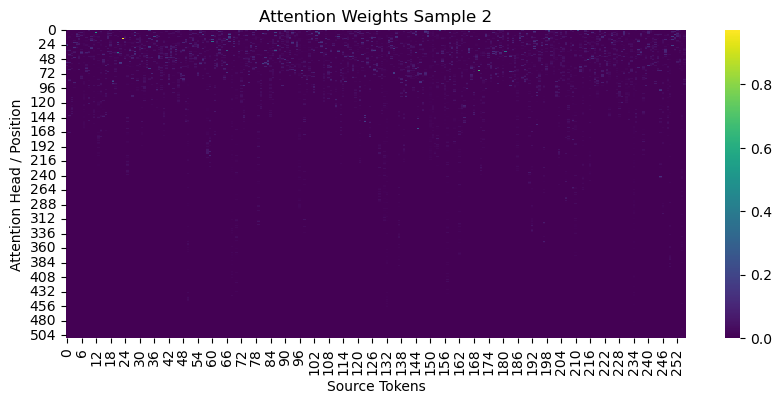

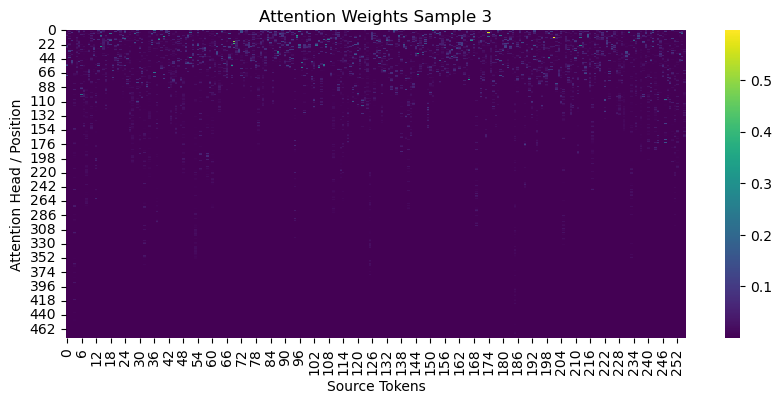

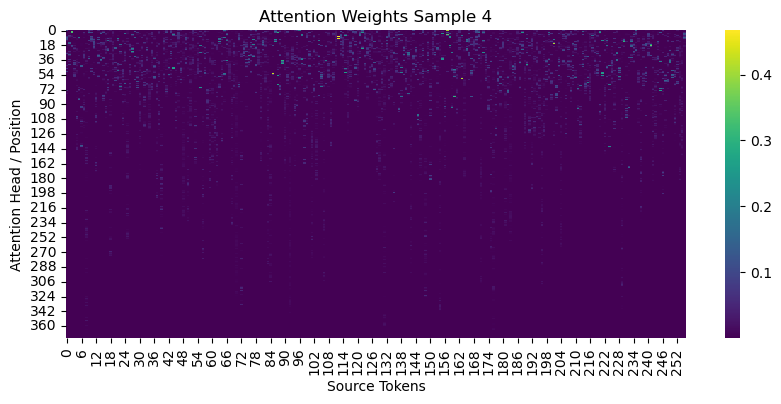

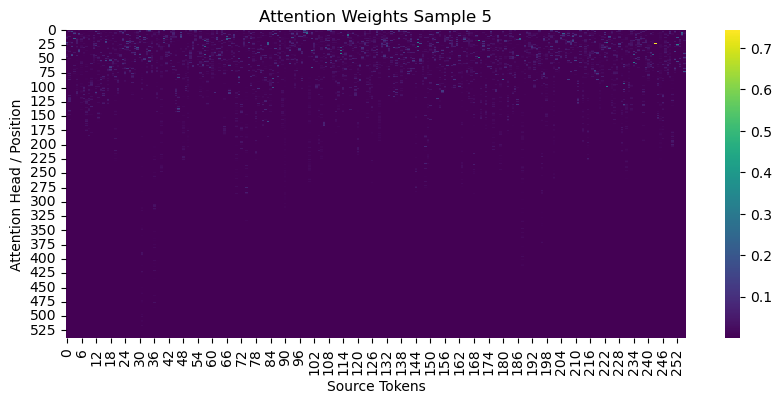

In [27]:
def evaluate_models_on_attention(attention_class, weights_dir="./weights", label_names=["neg","pos"]):
    """
    Applies a given attention mechanism to all 4 models (VanillaRNN, VanillaLSTM, BiRNN, BiLSTM)
    and evaluates them using the existing evaluate_model function.
    """
    encoders = [
        ("VanillaRNN", nn.RNN(200, 256, batch_first=True)),
        ("VanillaLSTM", nn.LSTM(200, 256, batch_first=True)),
        ("BiRNN", nn.RNN(200, 256, batch_first=True, bidirectional=True)),
        ("BiLSTM", nn.LSTM(200, 256, batch_first=True, bidirectional=True)),
    ]

    evals = {}

    for enc_name, enc in encoders:
        is_bi = getattr(enc, "bidirectional", False)
        enc_dim = 256 * (2 if is_bi else 1)

        attn = attention_class(enc_dim=enc_dim, dec_dim=enc_dim, att_dim=128)

        print(f"\n--- Evaluating {enc_name} + {attn.__class__.__name__} ---")

        model = AttentionClassifier(
            vocab_size=len(word2idx),
            embed_dim=200,
            hidden_dim=256,
            num_classes=2,
            encoder_rnn=enc,
            attention_mech=attn
        ).to(device)

        weight_file = f"{enc_name}_{attn.__class__.__name__}.pt"
        weight_path = os.path.join(weights_dir, weight_file)

        if not os.path.exists(weight_path):
            print(f"[skip] {weight_file} not found.")
            continue

        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.eval()

        # call your existing standardized evaluation
        evals[f"{enc_name}+{attn.__class__.__name__}"] = evaluate_model(
            model,
            test_loader,
            device=device,
            label_names=label_names,
            visualize_attention=True
        )

    return evals

evals.update(evaluate_models_on_attention(AdditiveAttention))

All the models have improved performance, with the Bidirectional LSTM being the best combination choice. Let us do the same with the other 3 attention types.


--- Evaluating VanillaRNN + DotAttention ---
Accuracy: 0.7144
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      2500
           1       0.72      0.71      0.71      2500

    accuracy                           0.71      5000
   macro avg       0.71      0.71      0.71      5000
weighted avg       0.71      0.71      0.71      5000

Confusion Matrix:
[[1799  701]
 [ 727 1773]]


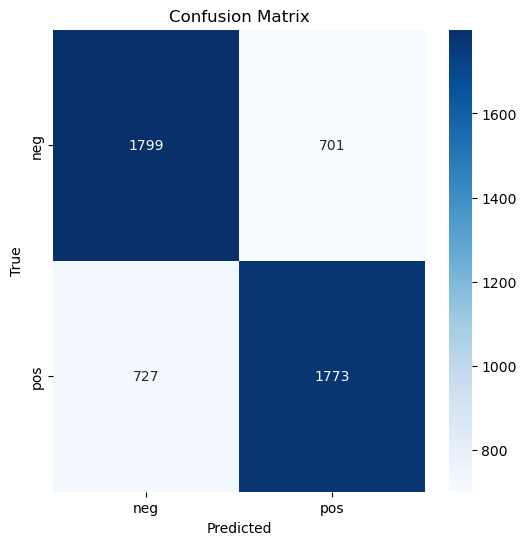

Visualizing attention for 5 random samples...


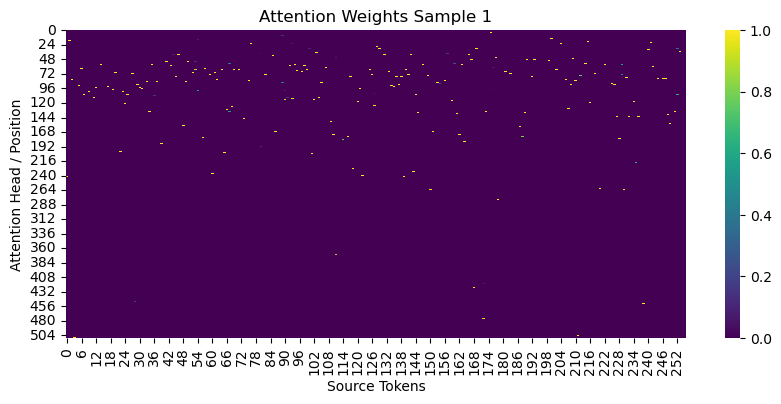

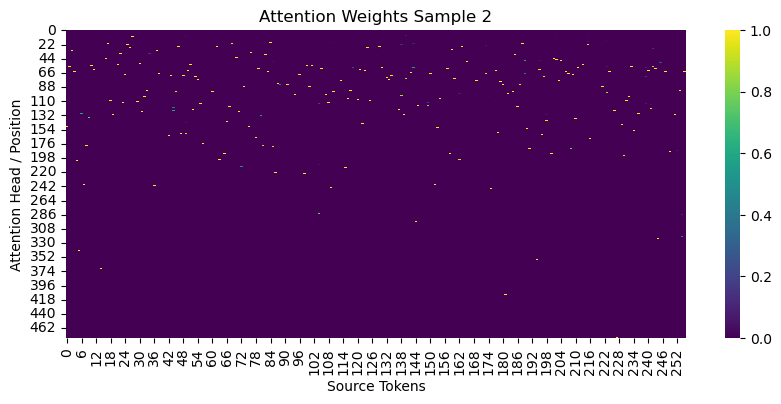

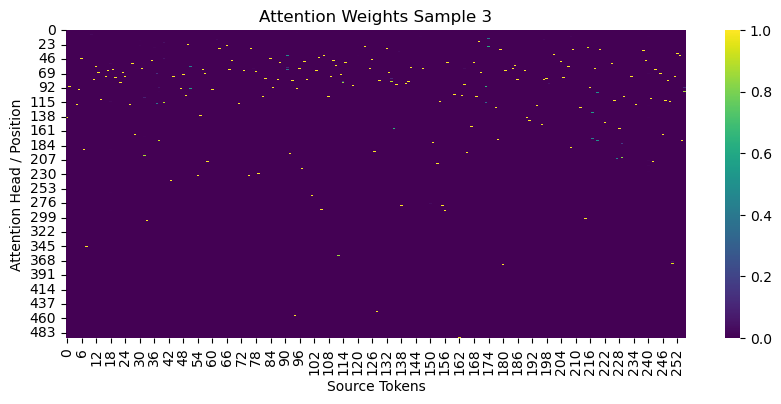

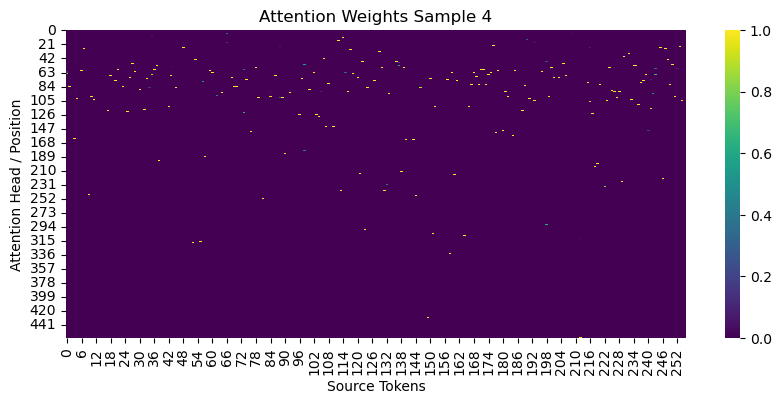

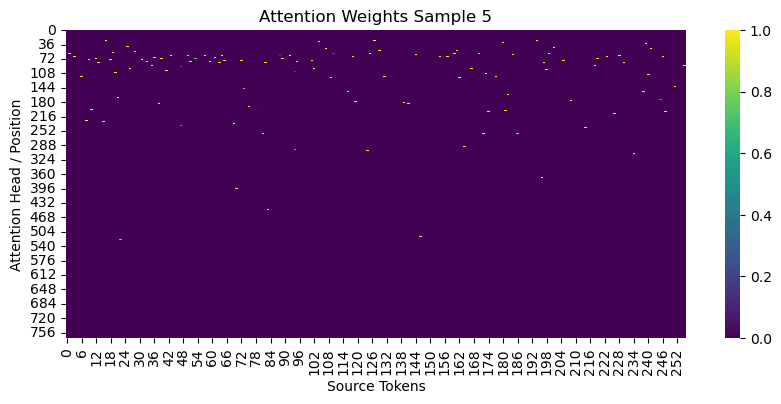


--- Evaluating VanillaLSTM + DotAttention ---
Accuracy: 0.8558
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      2500
           1       0.84      0.88      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Confusion Matrix:
[[2090  410]
 [ 311 2189]]


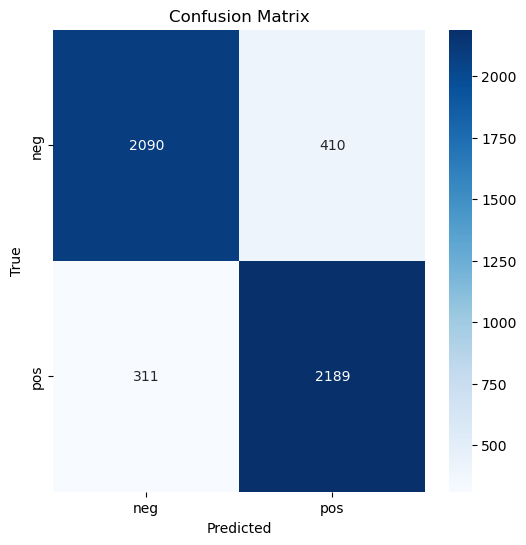

Visualizing attention for 5 random samples...


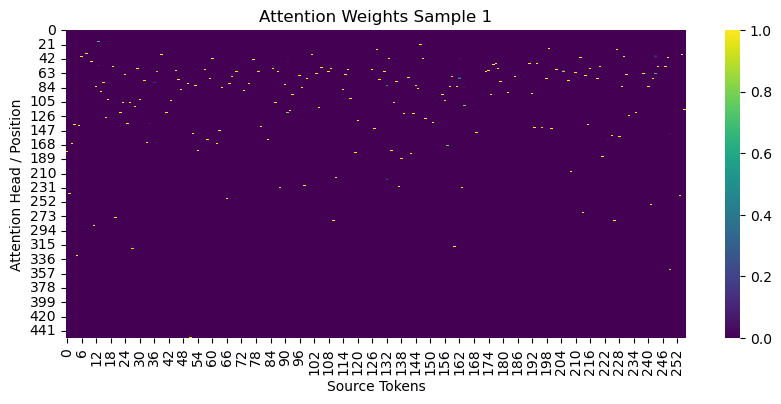

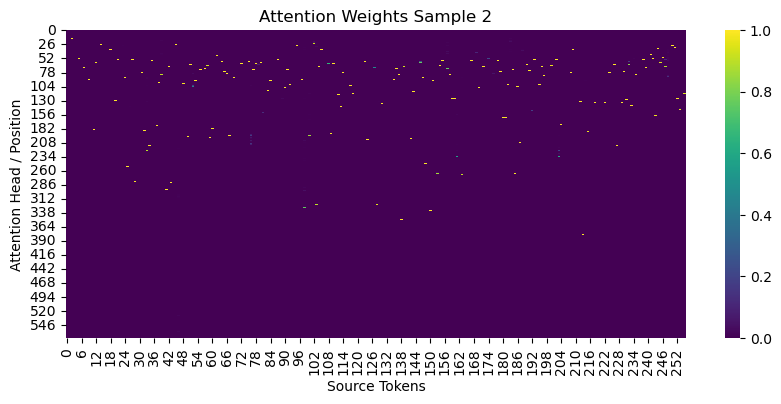

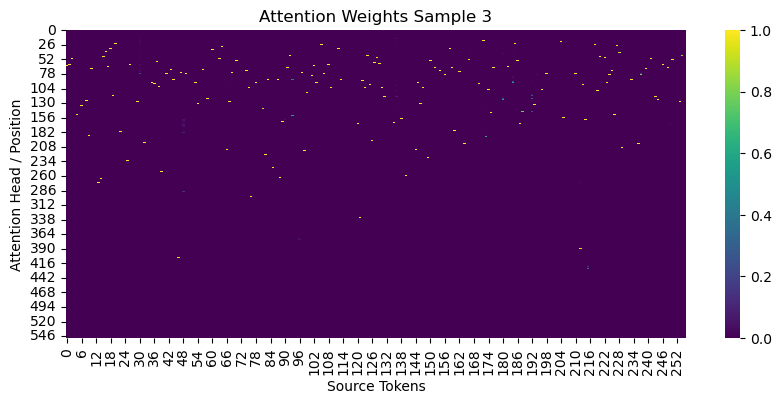

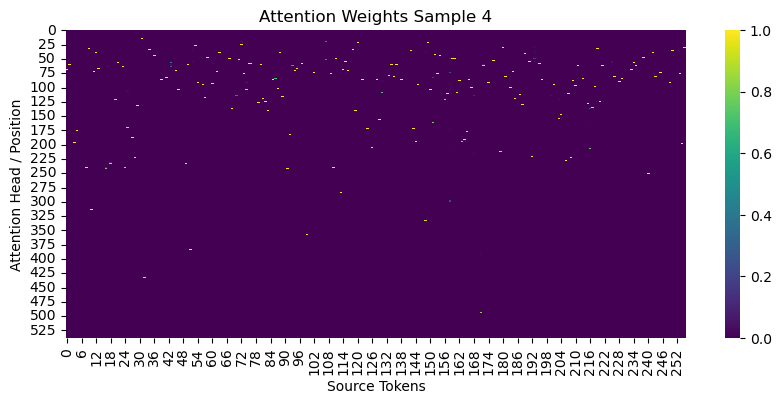

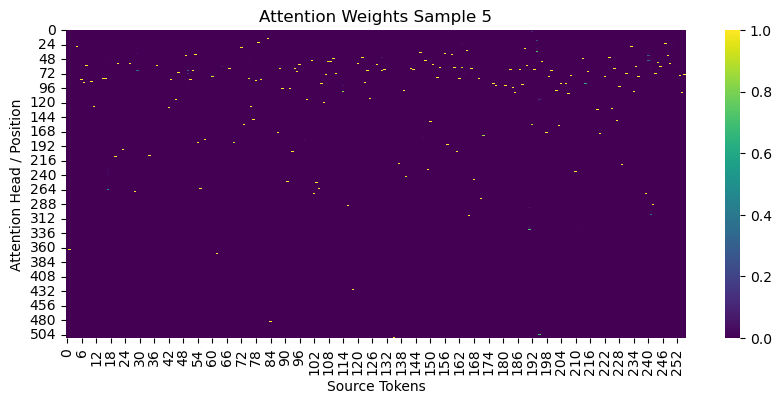


--- Evaluating BiRNN + DotAttention ---
Accuracy: 0.8038
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      2500
           1       0.80      0.80      0.80      2500

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000

Confusion Matrix:
[[2013  487]
 [ 494 2006]]


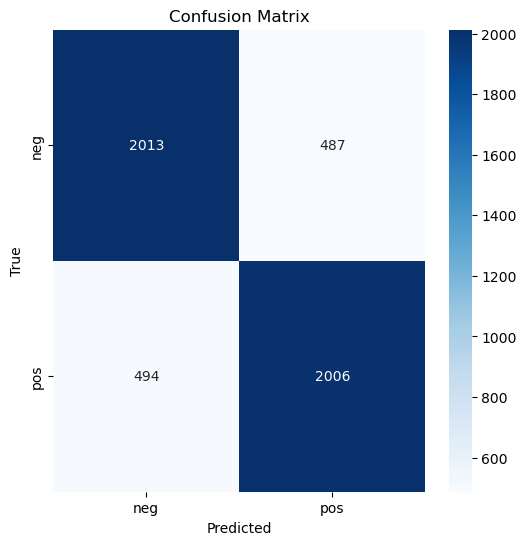

Visualizing attention for 5 random samples...


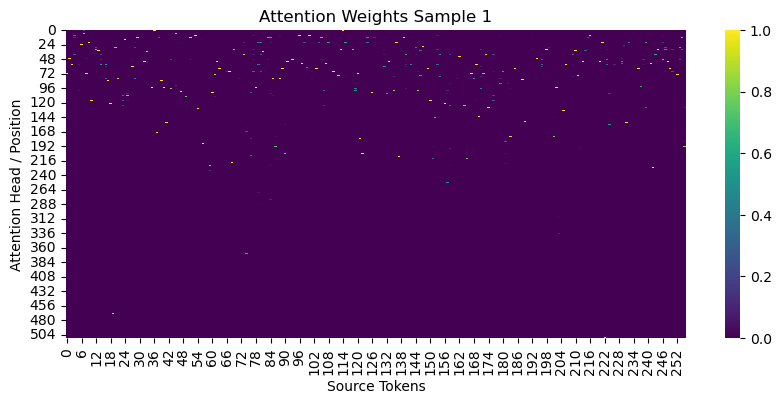

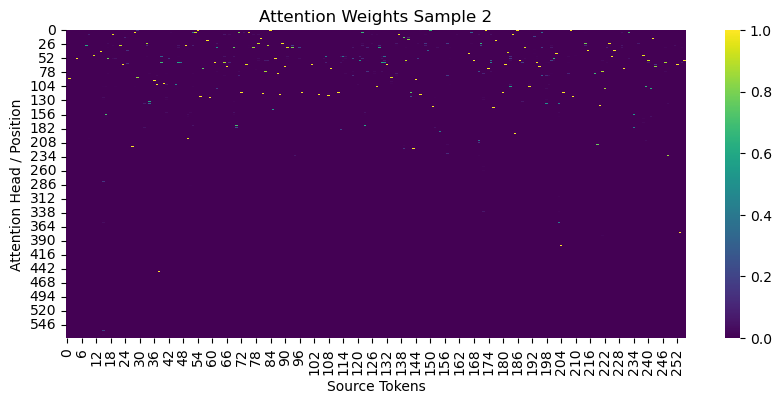

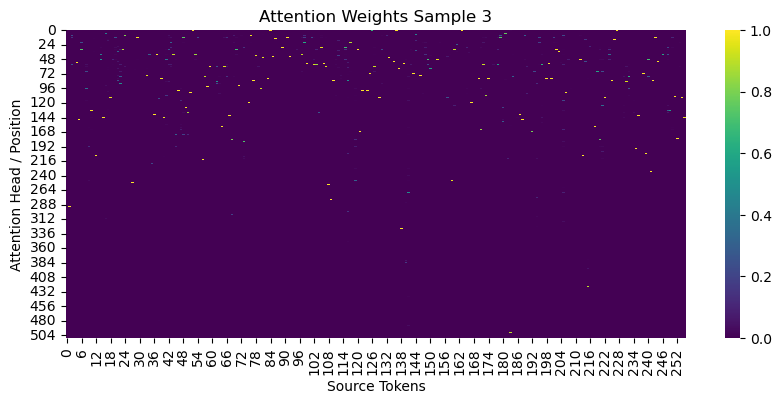

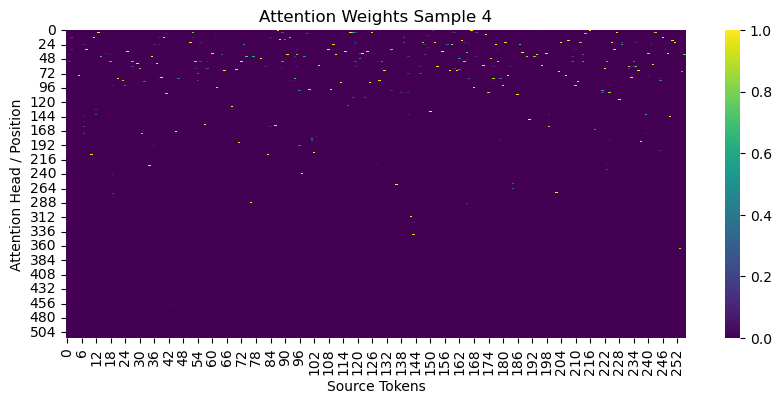

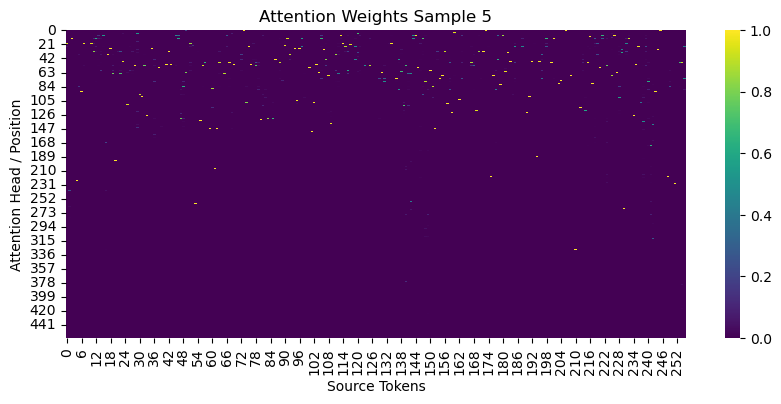


--- Evaluating BiLSTM + DotAttention ---
Accuracy: 0.8600
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2500
           1       0.86      0.86      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Confusion Matrix:
[[2147  353]
 [ 347 2153]]


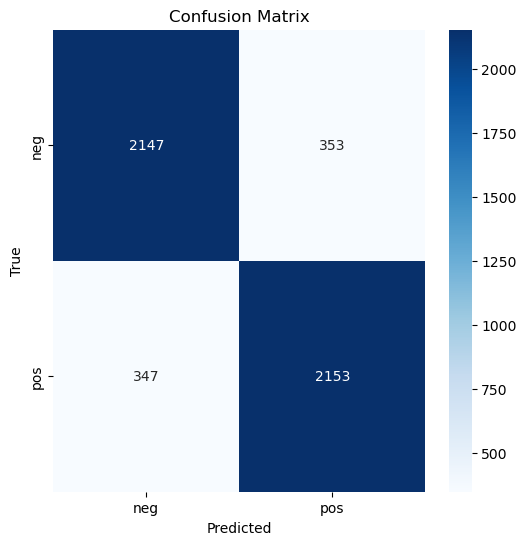

Visualizing attention for 5 random samples...


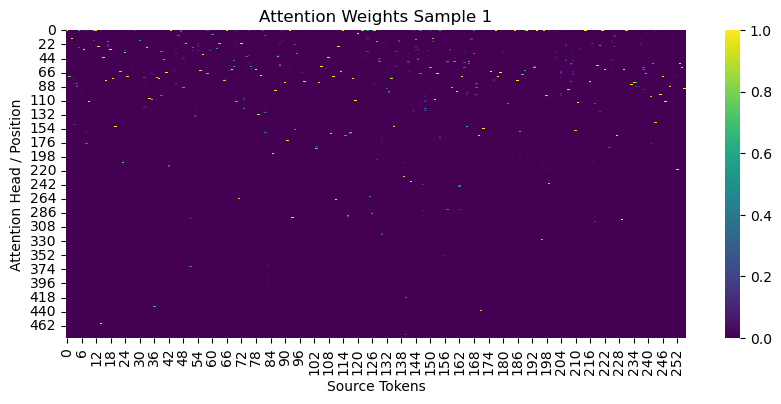

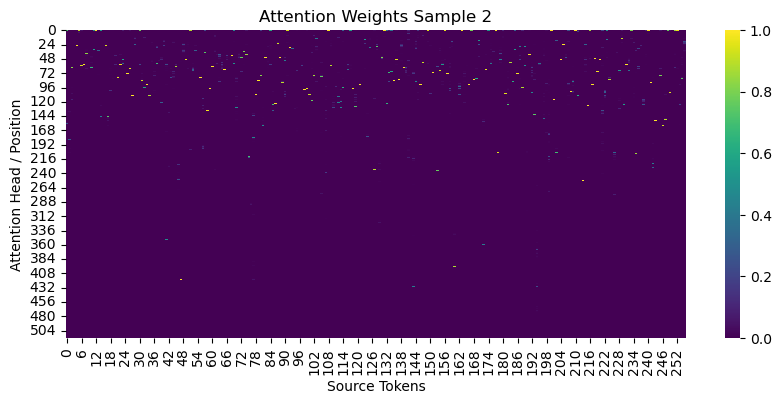

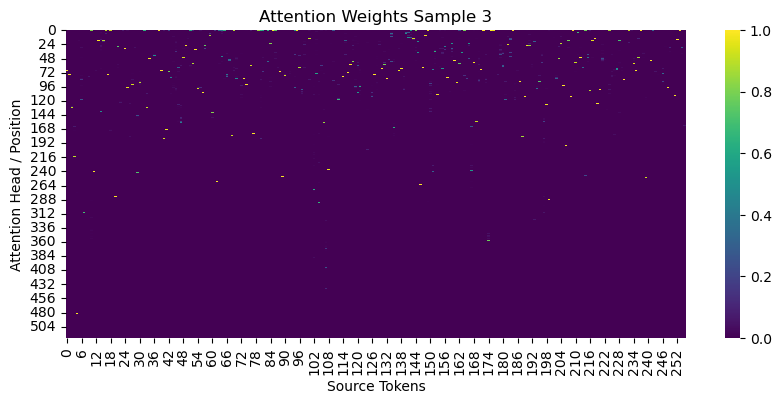

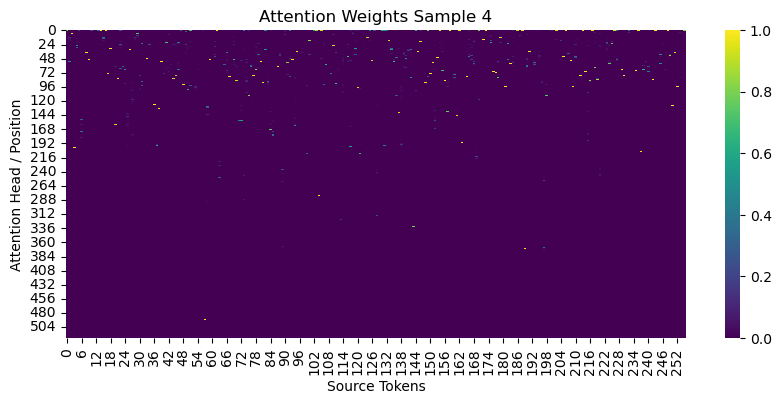

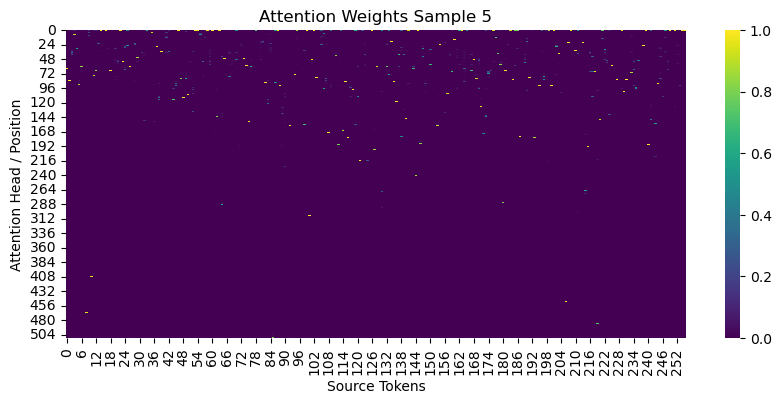

In [28]:
evals.update(evaluate_models_on_attention(DotAttention))

Next up, General Attention.


--- Evaluating VanillaRNN + GeneralAttention ---
Accuracy: 0.5392
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.37      0.44      2500
           1       0.53      0.71      0.61      2500

    accuracy                           0.54      5000
   macro avg       0.54      0.54      0.52      5000
weighted avg       0.54      0.54      0.52      5000

Confusion Matrix:
[[ 913 1587]
 [ 717 1783]]


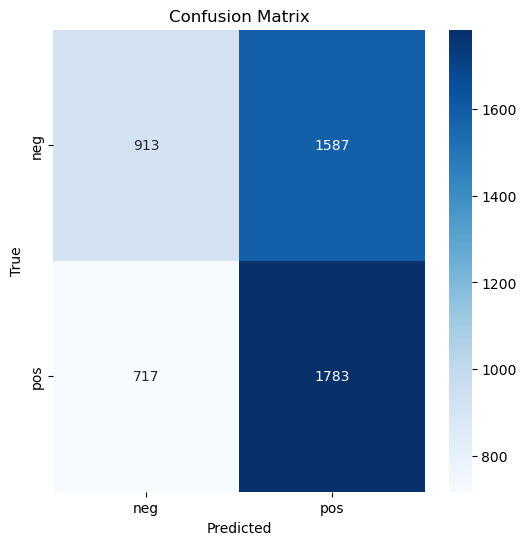

Visualizing attention for 5 random samples...


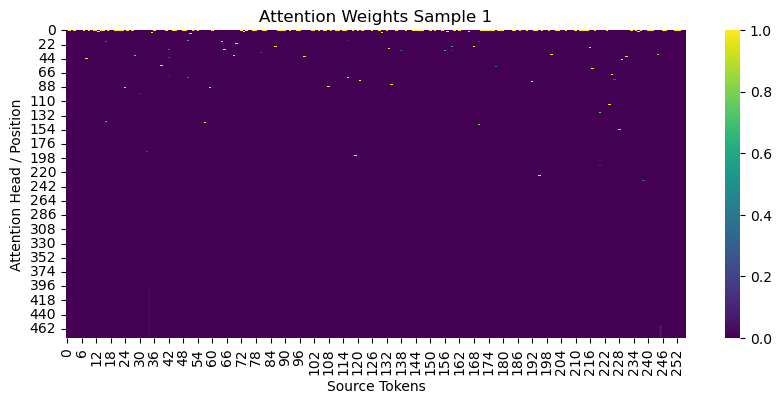

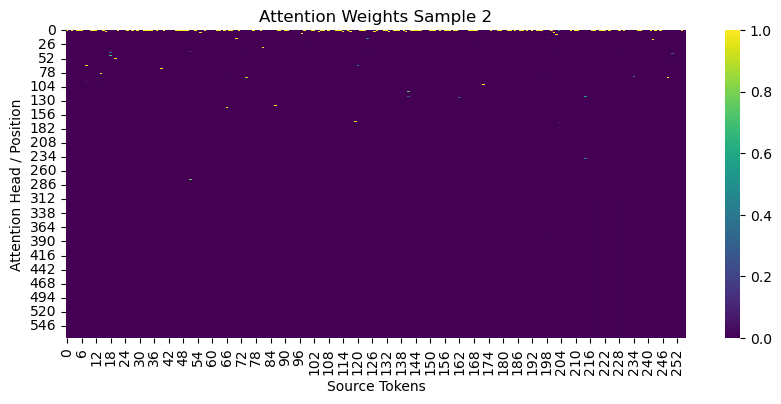

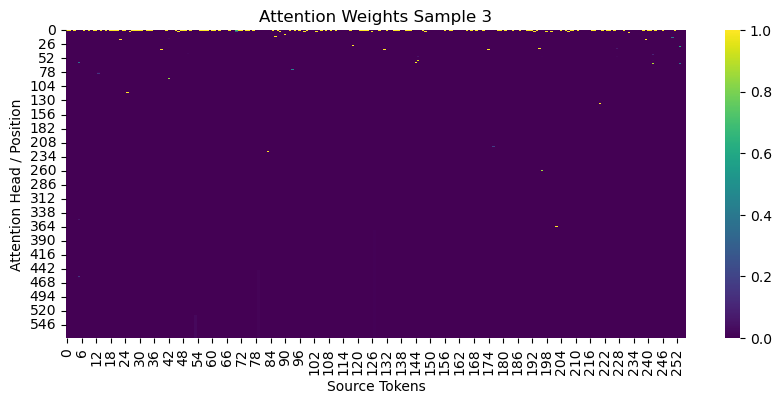

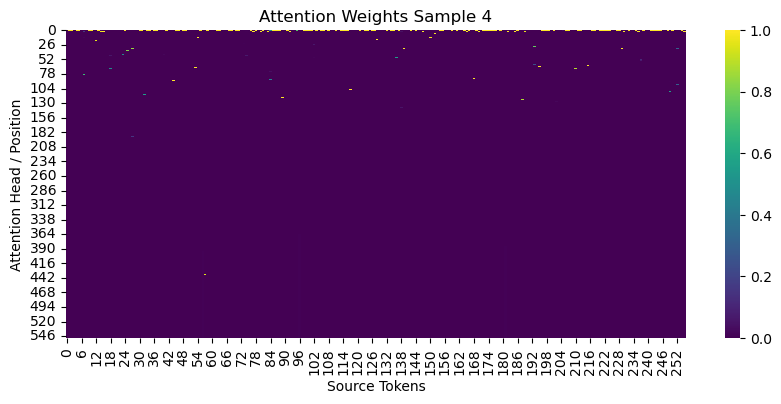

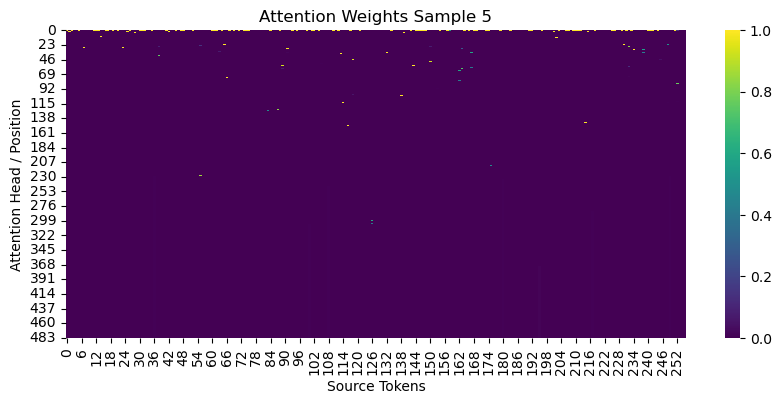


--- Evaluating VanillaLSTM + GeneralAttention ---
Accuracy: 0.8530
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      2500
           1       0.80      0.94      0.86      2500

    accuracy                           0.85      5000
   macro avg       0.86      0.85      0.85      5000
weighted avg       0.86      0.85      0.85      5000

Confusion Matrix:
[[1915  585]
 [ 150 2350]]


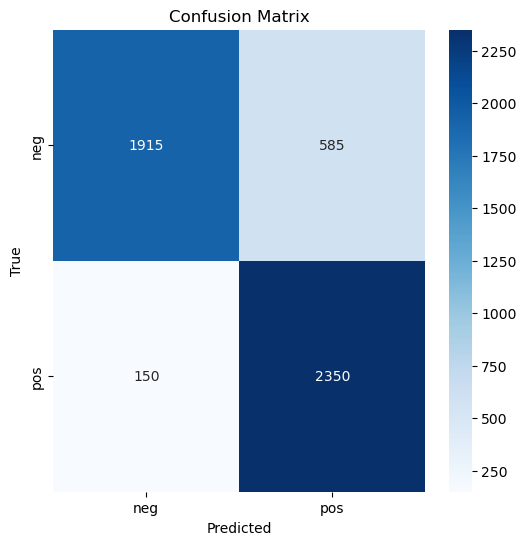

Visualizing attention for 5 random samples...


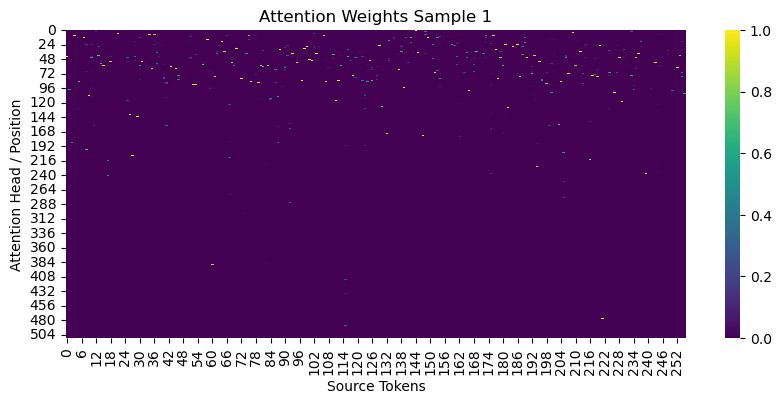

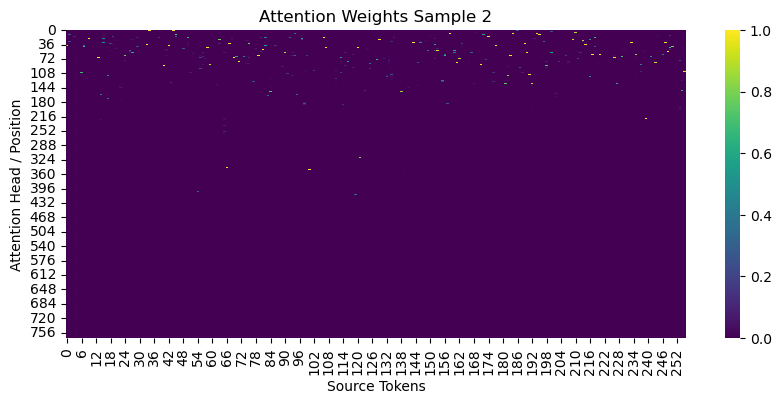

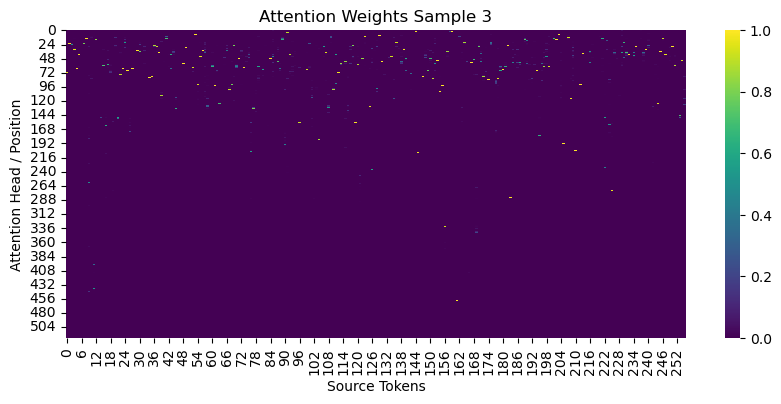

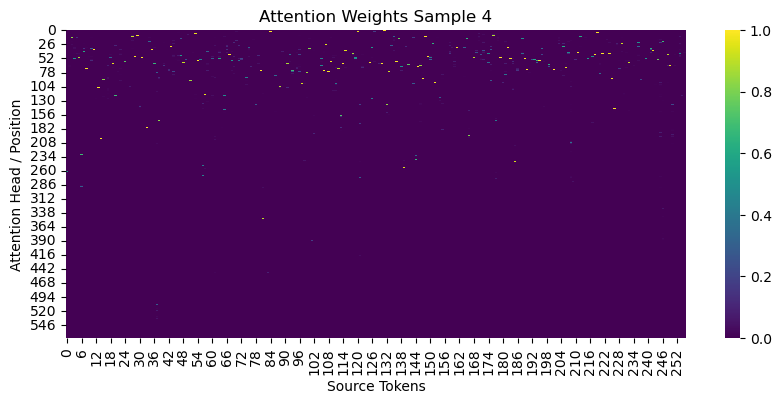

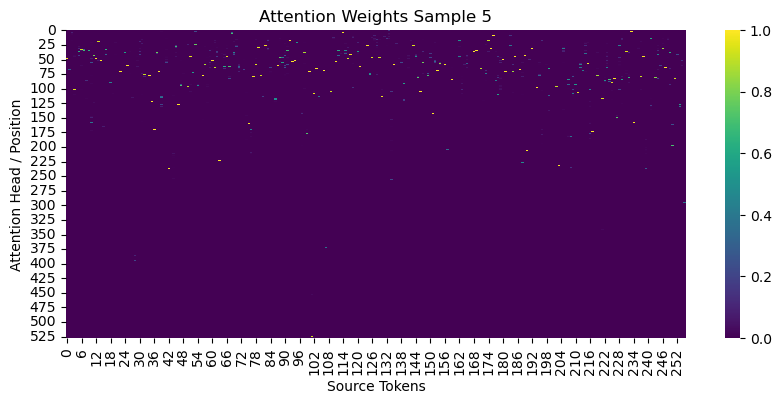


--- Evaluating BiRNN + GeneralAttention ---
Accuracy: 0.5210
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      2500
           1       0.52      0.54      0.53      2500

    accuracy                           0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.52      0.52      0.52      5000

Confusion Matrix:
[[1250 1250]
 [1145 1355]]


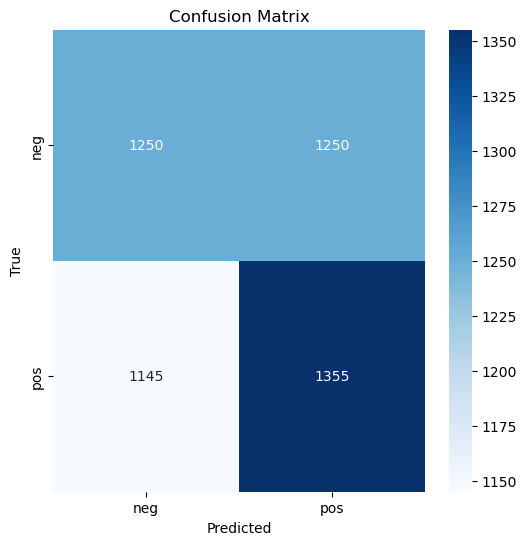

Visualizing attention for 5 random samples...


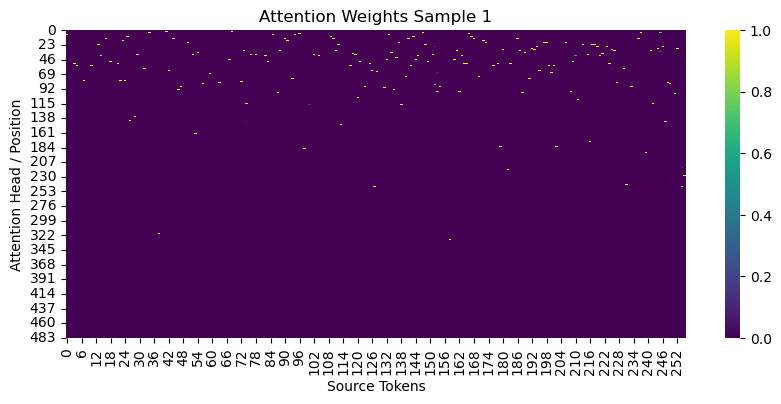

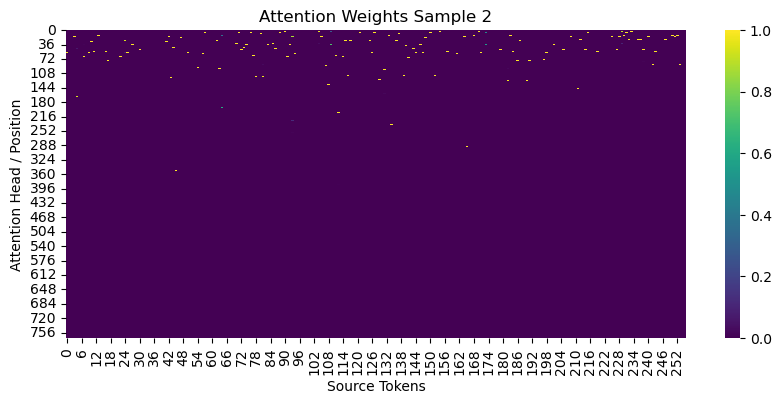

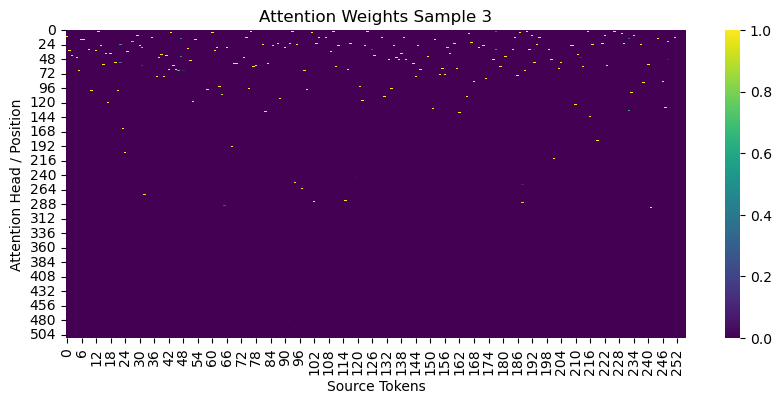

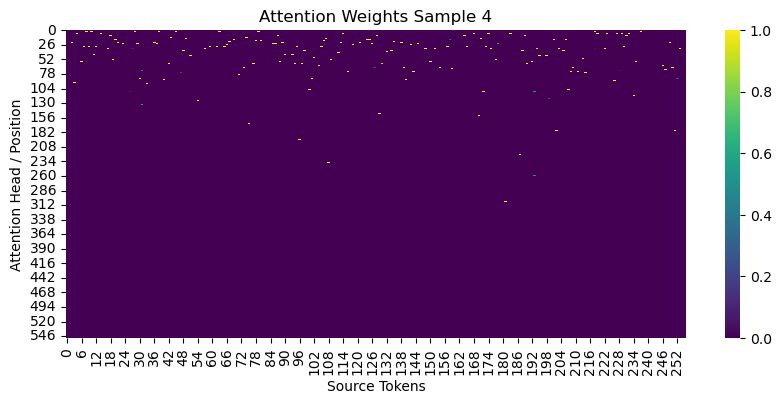

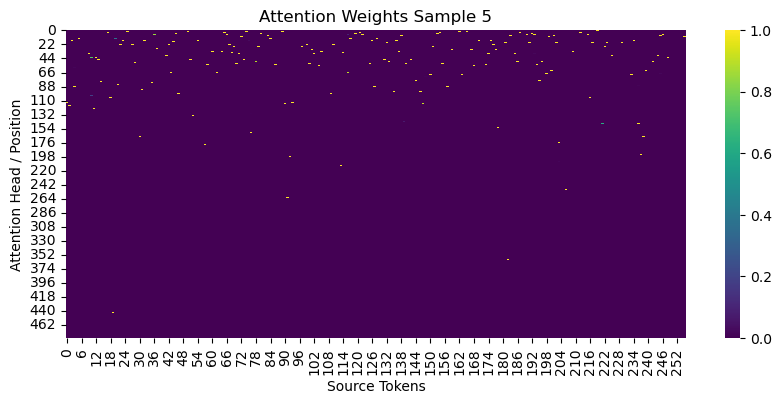


--- Evaluating BiLSTM + GeneralAttention ---
Accuracy: 0.8598
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      2500
           1       0.83      0.91      0.87      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Confusion Matrix:
[[2030  470]
 [ 231 2269]]


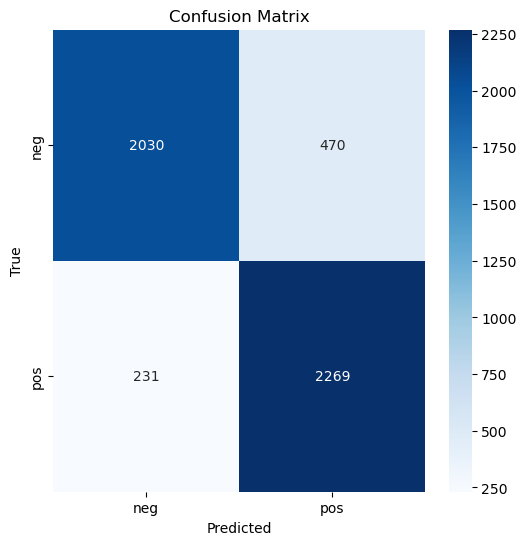

Visualizing attention for 5 random samples...


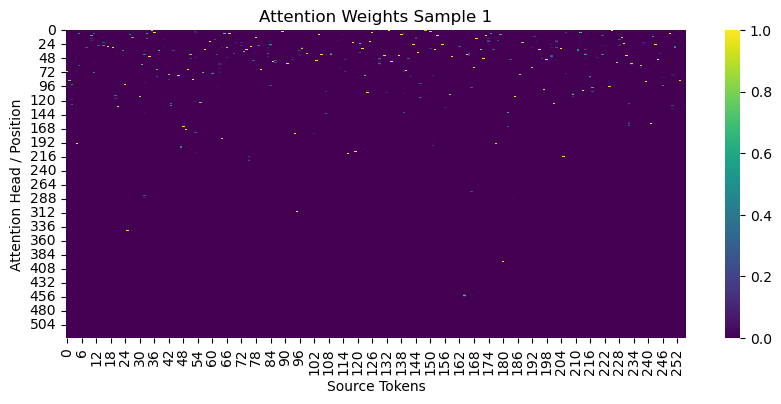

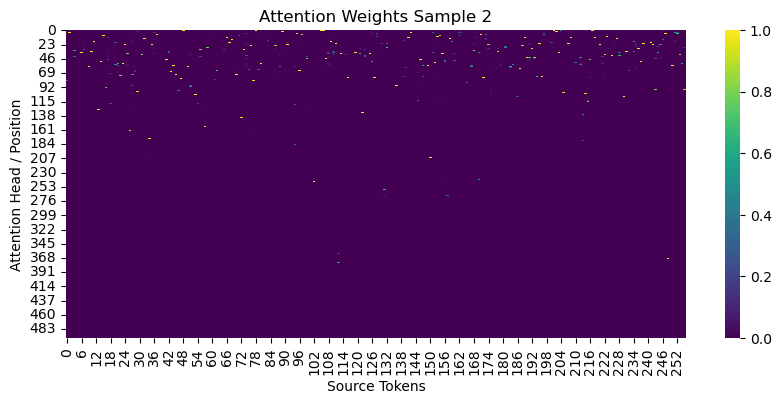

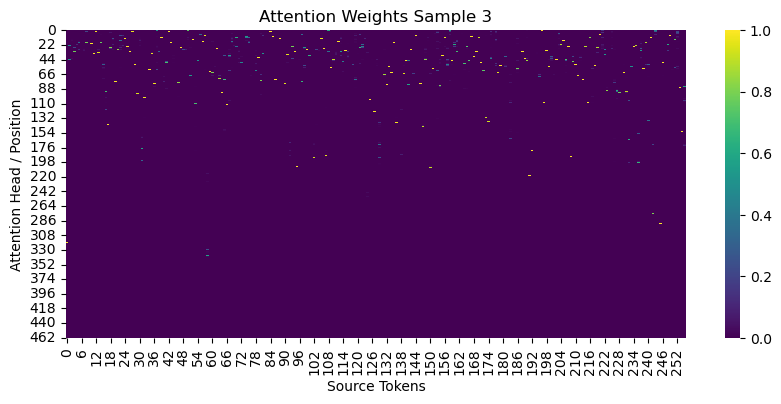

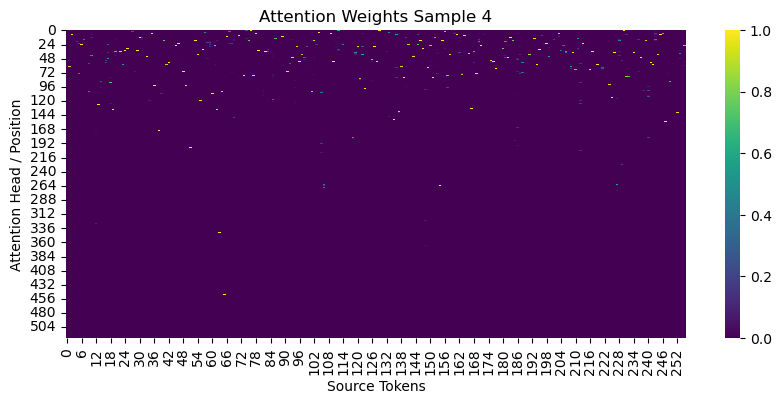

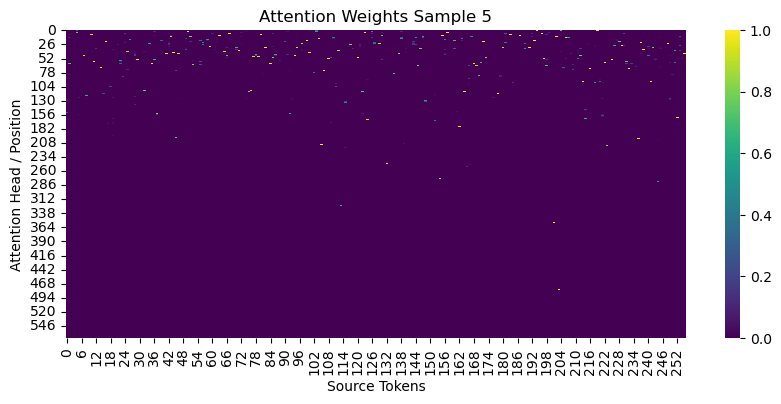

In [30]:
evals.update(evaluate_models_on_attention(GeneralAttention))


--- Evaluating VanillaRNN + ConcatAttention ---
Accuracy: 0.7108
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.47      0.62      2500
           1       0.64      0.95      0.77      2500

    accuracy                           0.71      5000
   macro avg       0.78      0.71      0.69      5000
weighted avg       0.78      0.71      0.69      5000

Confusion Matrix:
[[1171 1329]
 [ 117 2383]]


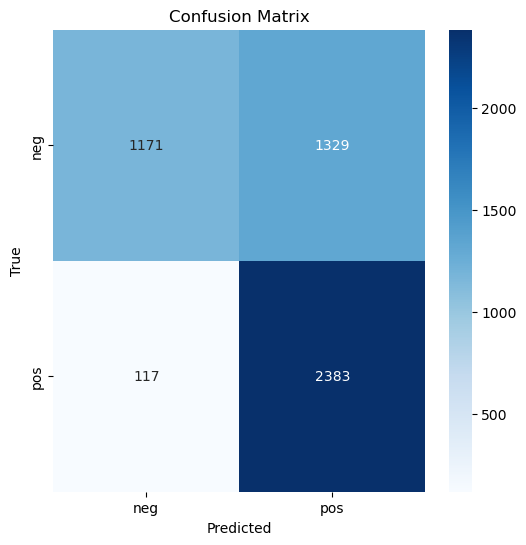

Visualizing attention for 5 random samples...


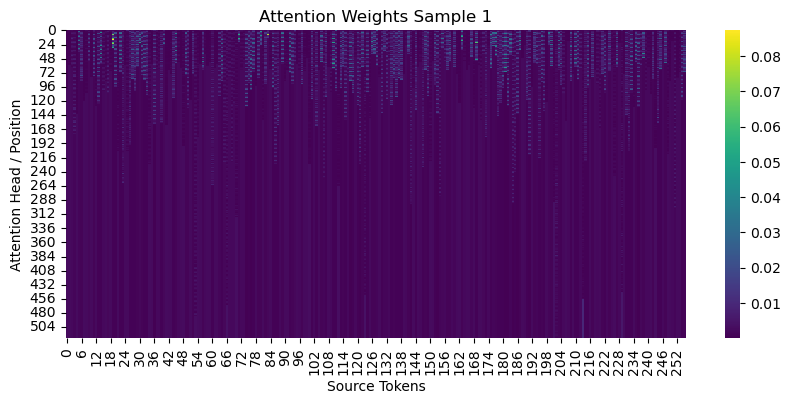

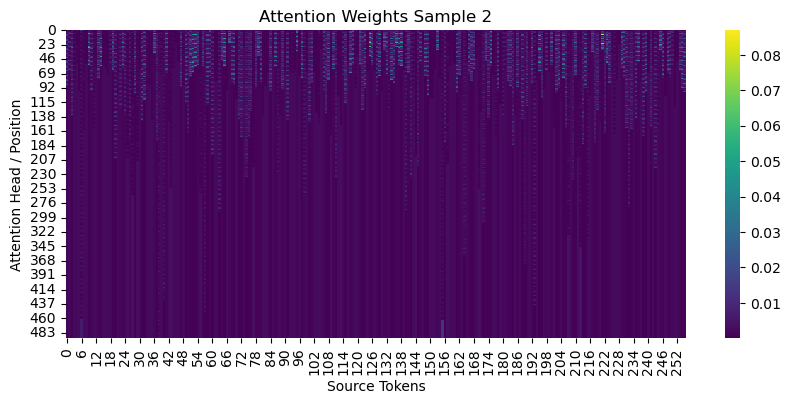

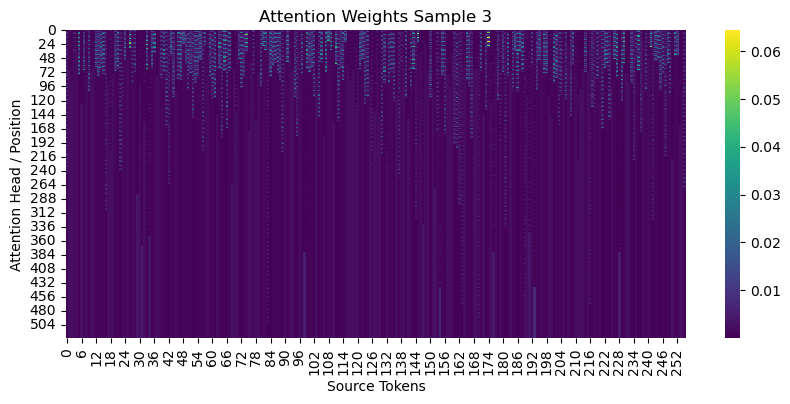

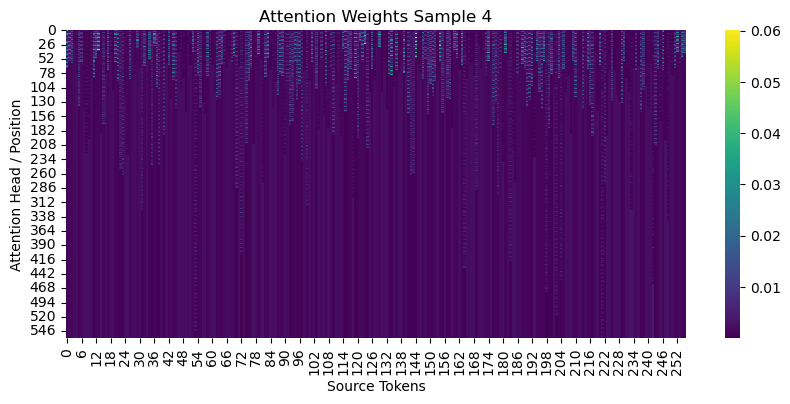

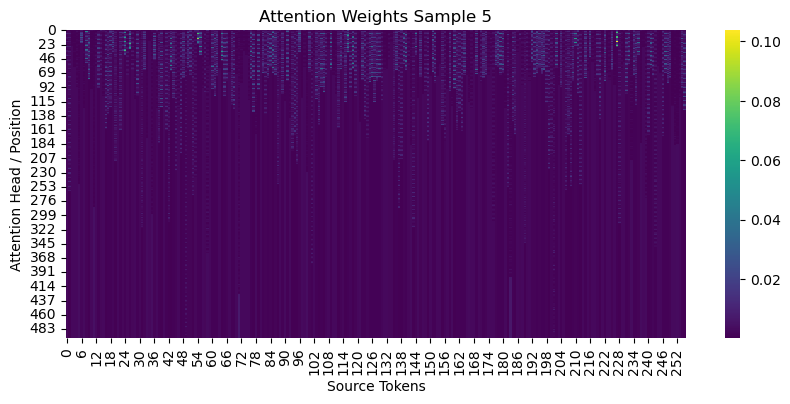


--- Evaluating VanillaLSTM + ConcatAttention ---
Accuracy: 0.8606
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2500
           1       0.85      0.88      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Confusion Matrix:
[[2103  397]
 [ 300 2200]]


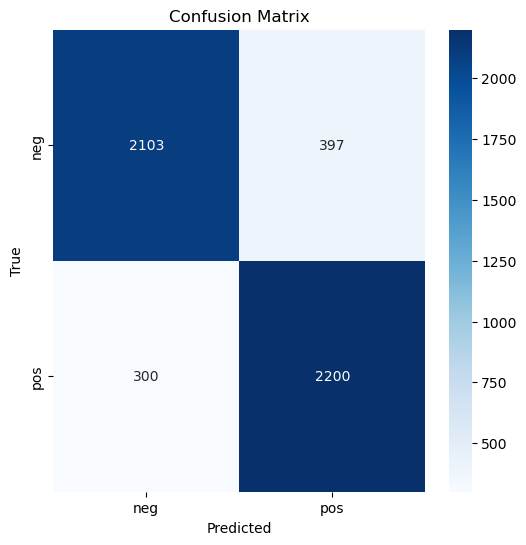

Visualizing attention for 5 random samples...


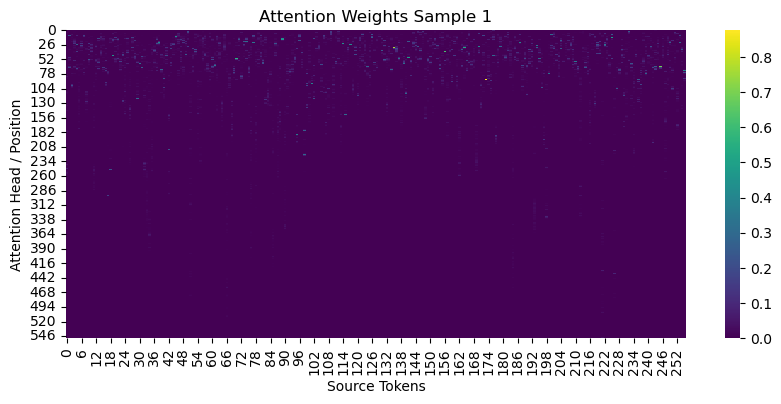

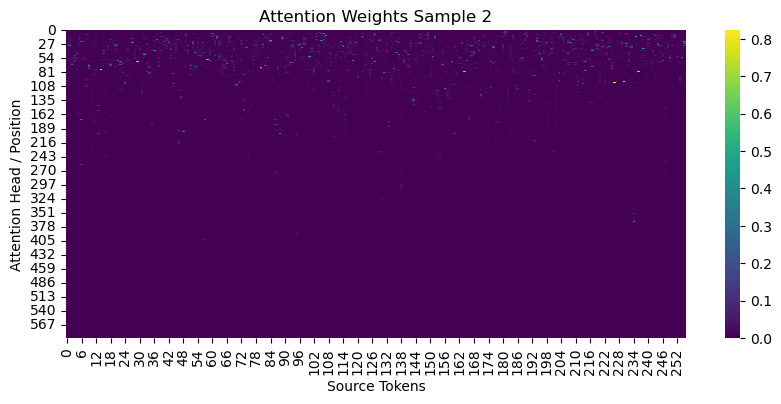

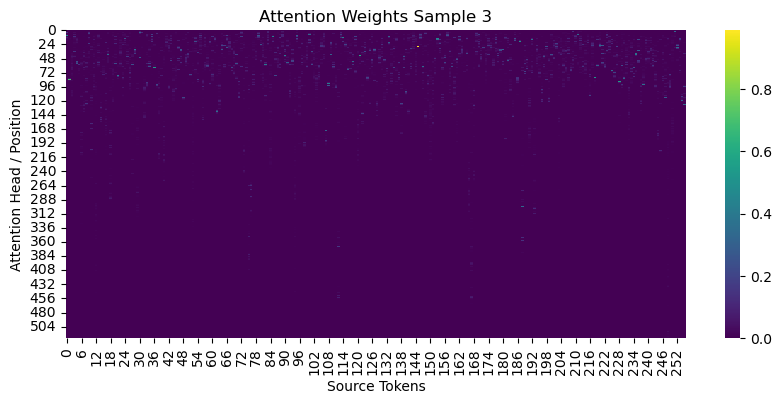

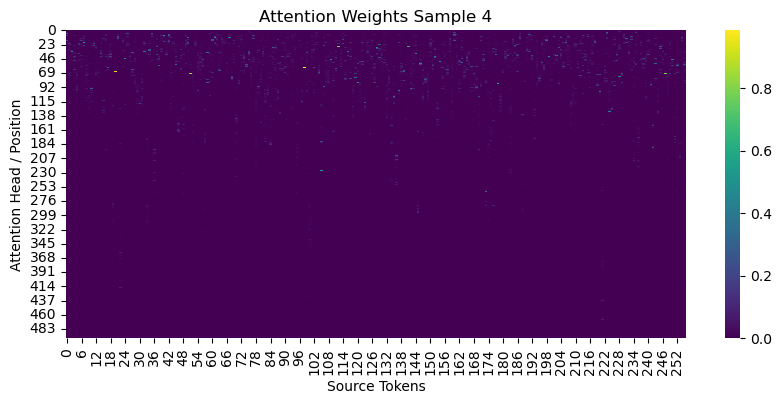

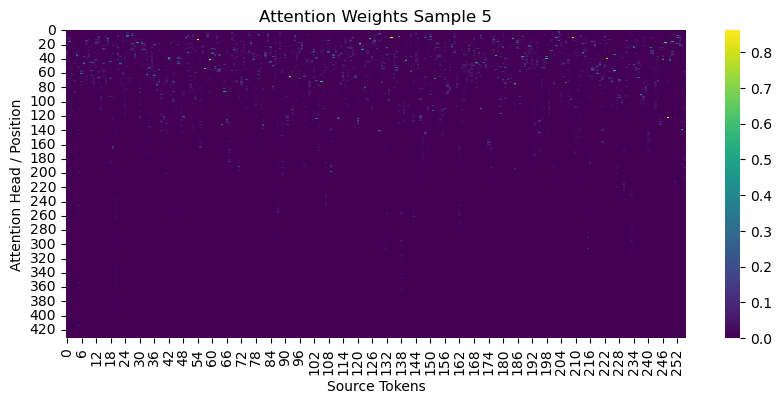


--- Evaluating BiRNN + ConcatAttention ---
Accuracy: 0.8580
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2500
           1       0.86      0.86      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Confusion Matrix:
[[2144  356]
 [ 354 2146]]


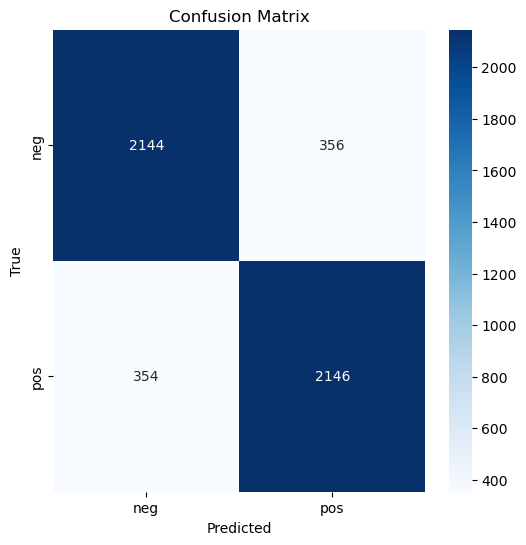

Visualizing attention for 5 random samples...


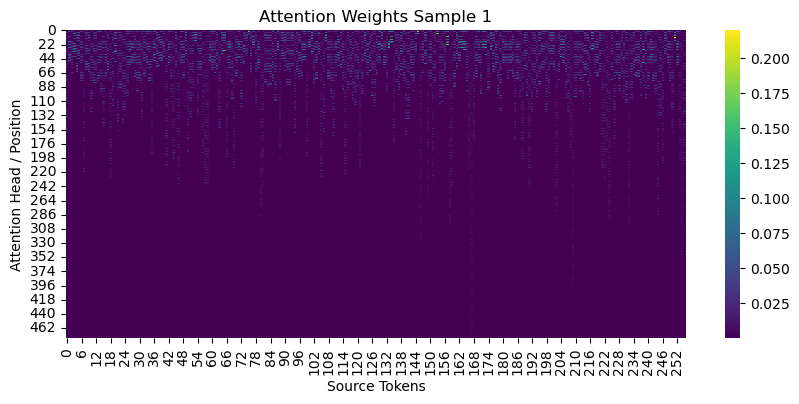

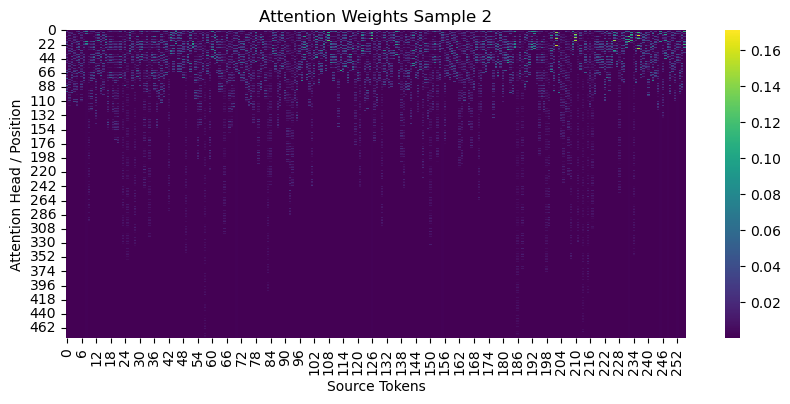

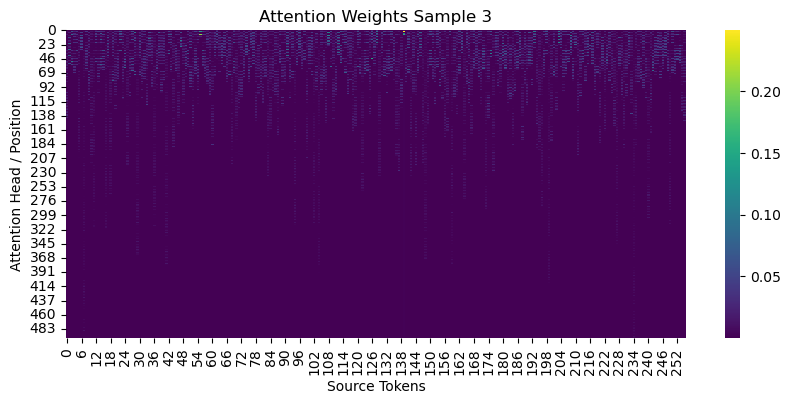

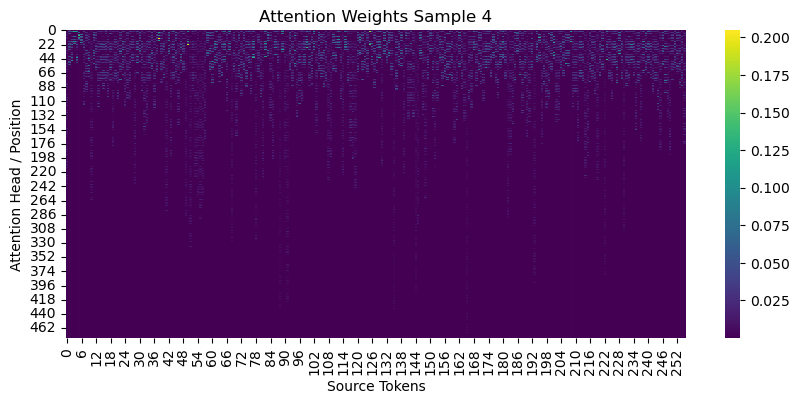

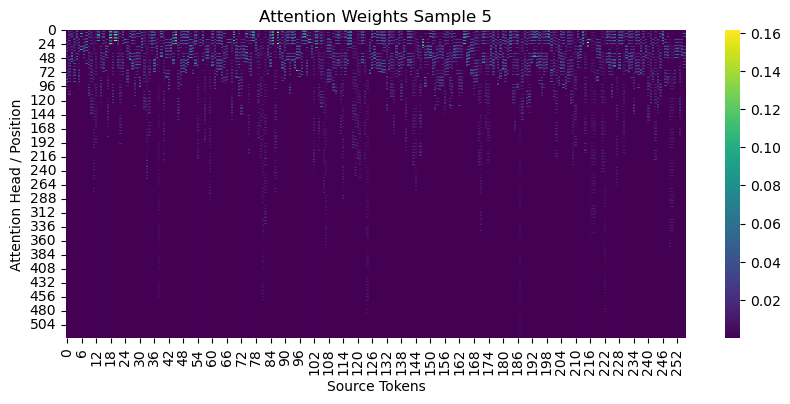


--- Evaluating BiLSTM + ConcatAttention ---
Accuracy: 0.8658
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2500
           1       0.86      0.87      0.87      2500

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion Matrix:
[[2146  354]
 [ 317 2183]]


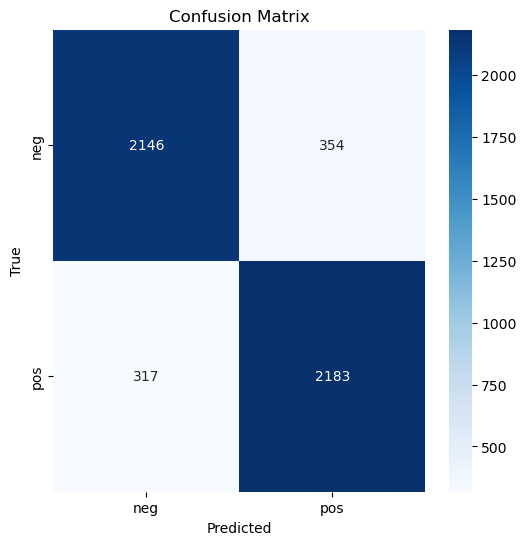

Visualizing attention for 5 random samples...


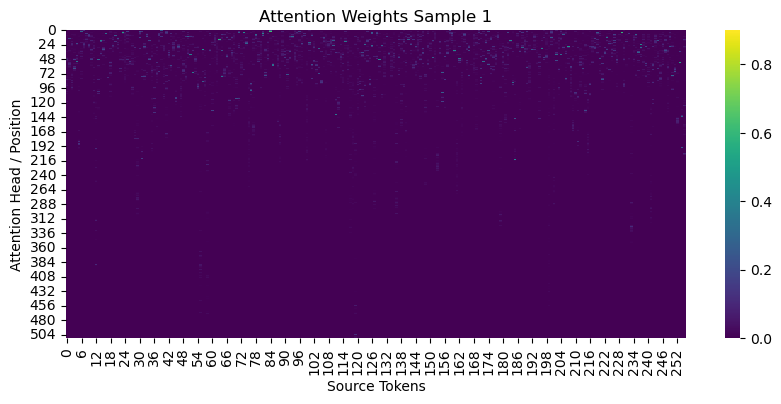

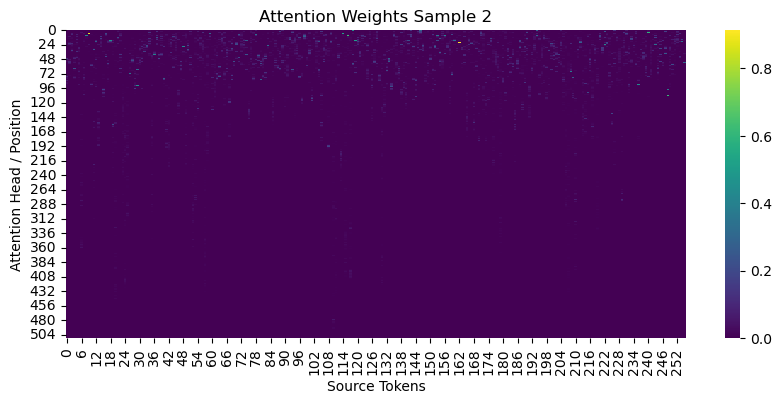

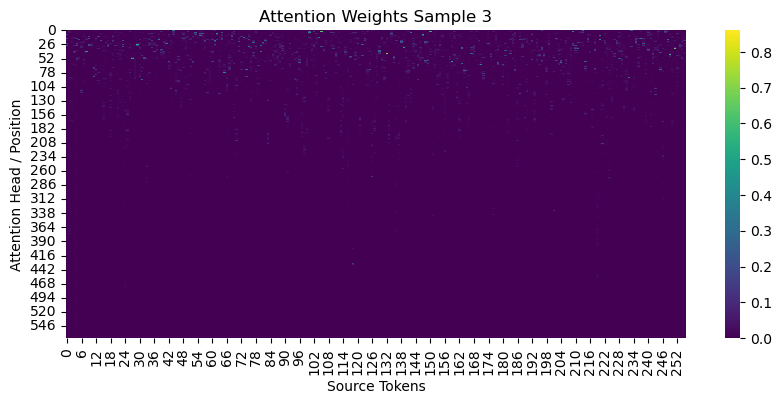

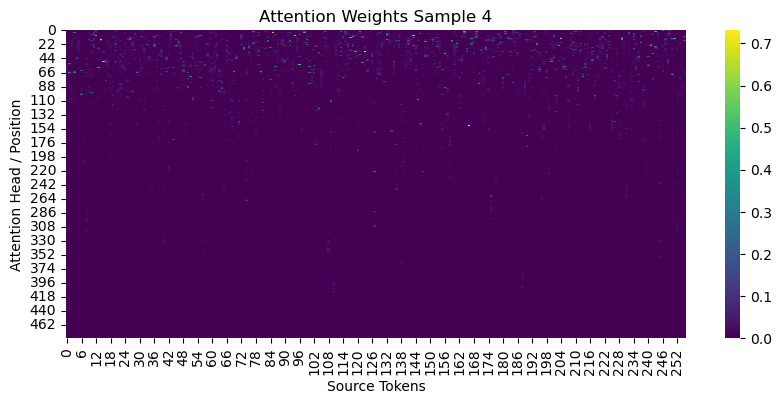

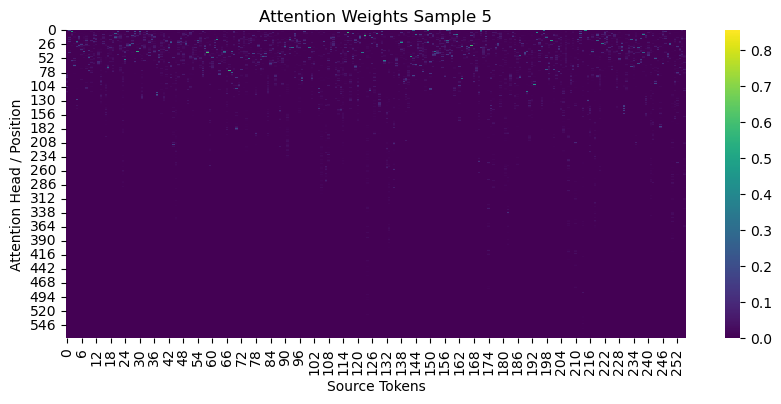

In [31]:
evals.update(evaluate_models_on_attention(ConcatAttention))

Time to compile it all together!

In [32]:
import pandas as pd

results = [
    ["VanillaRNN", 0.8178, 0.8180, 0.8178, 0.8178, [[2079,421],[490,2010]]],
    ["VanillaLSTM", 0.8596, 0.8643, 0.8596, 0.8591, [[2007,493],[209,2291]]],
    ["BiRNN", 0.8214, 0.8217, 0.8214, 0.8214, [[2093,407],[486,2014]]],
    ["BiLSTM", 0.8396, 0.8404, 0.8396, 0.8395, [[2160,340],[462,2038]]],
    ["VanillaRNN + Additive", 0.8620, 0.8620, 0.8620, 0.8620, [[2153,347],[343,2157]]],
    ["VanillaLSTM + Additive", 0.8744, 0.8744, 0.8744, 0.8744, [[2174,326],[302,2198]]],
    ["BiRNN + Additive", 0.8654, 0.8662, 0.8654, 0.8653, [[2222,278],[395,2105]]],
    ["BiLSTM + Additive", 0.8780, 0.8791, 0.8780, 0.8779, [[2129,371],[239,2261]]],
    ["VanillaRNN + Dot", 0.7146, 0.7146, 0.7146, 0.7146, [[1799,701],[726,1774]]],
    ["VanillaLSTM + Dot", 0.8558, 0.8564, 0.8558, 0.8557, [[2090,410],[311,2189]]],
    ["BiRNN + Dot", 0.8034, 0.8034, 0.8034, 0.8034, [[2012,488],[495,2005]]],
    ["BiLSTM + Dot", 0.8600, 0.8600, 0.8600, 0.8600, [[2147,353],[347,2153]]],
    ["VanillaRNN + General", 0.5394, 0.5448, 0.5394, 0.5250, [[913,1587],[716,1784]]],
    ["VanillaLSTM + General", 0.8530, 0.8640, 0.8530, 0.8519, [[1915,585],[150,2350]]],
    ["BiRNN + General", 0.5210, 0.5210, 0.5210, 0.5208, [[1250,1250],[1145,1355]]],
    ["BiLSTM + General", 0.8598, 0.8631, 0.8598, 0.8595, [[2030,470],[231,2269]]],
    ["VanillaRNN + Concat", 0.7104, 0.7748, 0.7104, 0.6924, [[1171,1329],[119,2381]]],
    ["VanillaLSTM + Concat", 0.8606, 0.8611, 0.8606, 0.8605, [[2103,397],[300,2200]]],
    ["BiRNN + Concat", 0.8580, 0.8580, 0.8580, 0.8580, [[2144,356],[354,2146]]],
    ["BiLSTM + Concat", 0.8658, 0.8659, 0.8658, 0.8658, [[2146,354],[317,2183]]],
]

df = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "Precision", "Recall", "F1-score", "Confusion Matrix"
])

# style highlight:
styled_df = (
    df.style
    .background_gradient(subset=["Accuracy", "F1-score"], cmap="YlGn")
    .format({
        "Accuracy": "{:.3f}",
        "Precision": "{:.3f}",
        "Recall": "{:.3f}",
        "F1-score": "{:.3f}"
    })
)

styled_df


From here, we can deduce that LSTMs perform the best with attention mechanisms, and within those, Additive Attention tends to perform the best.